In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
import astropy.constants as const
import astropy.units as u
import importlib
from astropy.modeling import models, fitting



#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/yz_cmi/'
stis_specs = glob.glob('{}hst/stis/*x1d.fits'.format(path))
cos_specs = glob.glob('{}hst/cos/*x1dsum.fits'.format(path))
print(cos_specs)

['/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cos/lf7111010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cos/lf7109010_x1dsum.fits', '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cos/lf71z9010_x1dsum.fits']


In [3]:
# # fig, ax = plt.subplots()

# for x in np.hstack((stis_specs, cos_specs)):
#     fig, ax = plt.subplots()
    
#     data = fits.getdata(x, 1)
#     for dt in data[::-1]:
#         w, f, e = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'] 
#         # ax.step(dt['WAVELENGTH'], dt['FLUX'])
#         # mask = (w < 1120) | w < 1160
#         ax.step(w, f, where='mid')
#     ax.set_yscale('log')

1163.3911 2835.337
1065.5724 1545.3041
1778.1298 2022.7762
2302.9382 3072.4956


(1750.0, 2100.0)

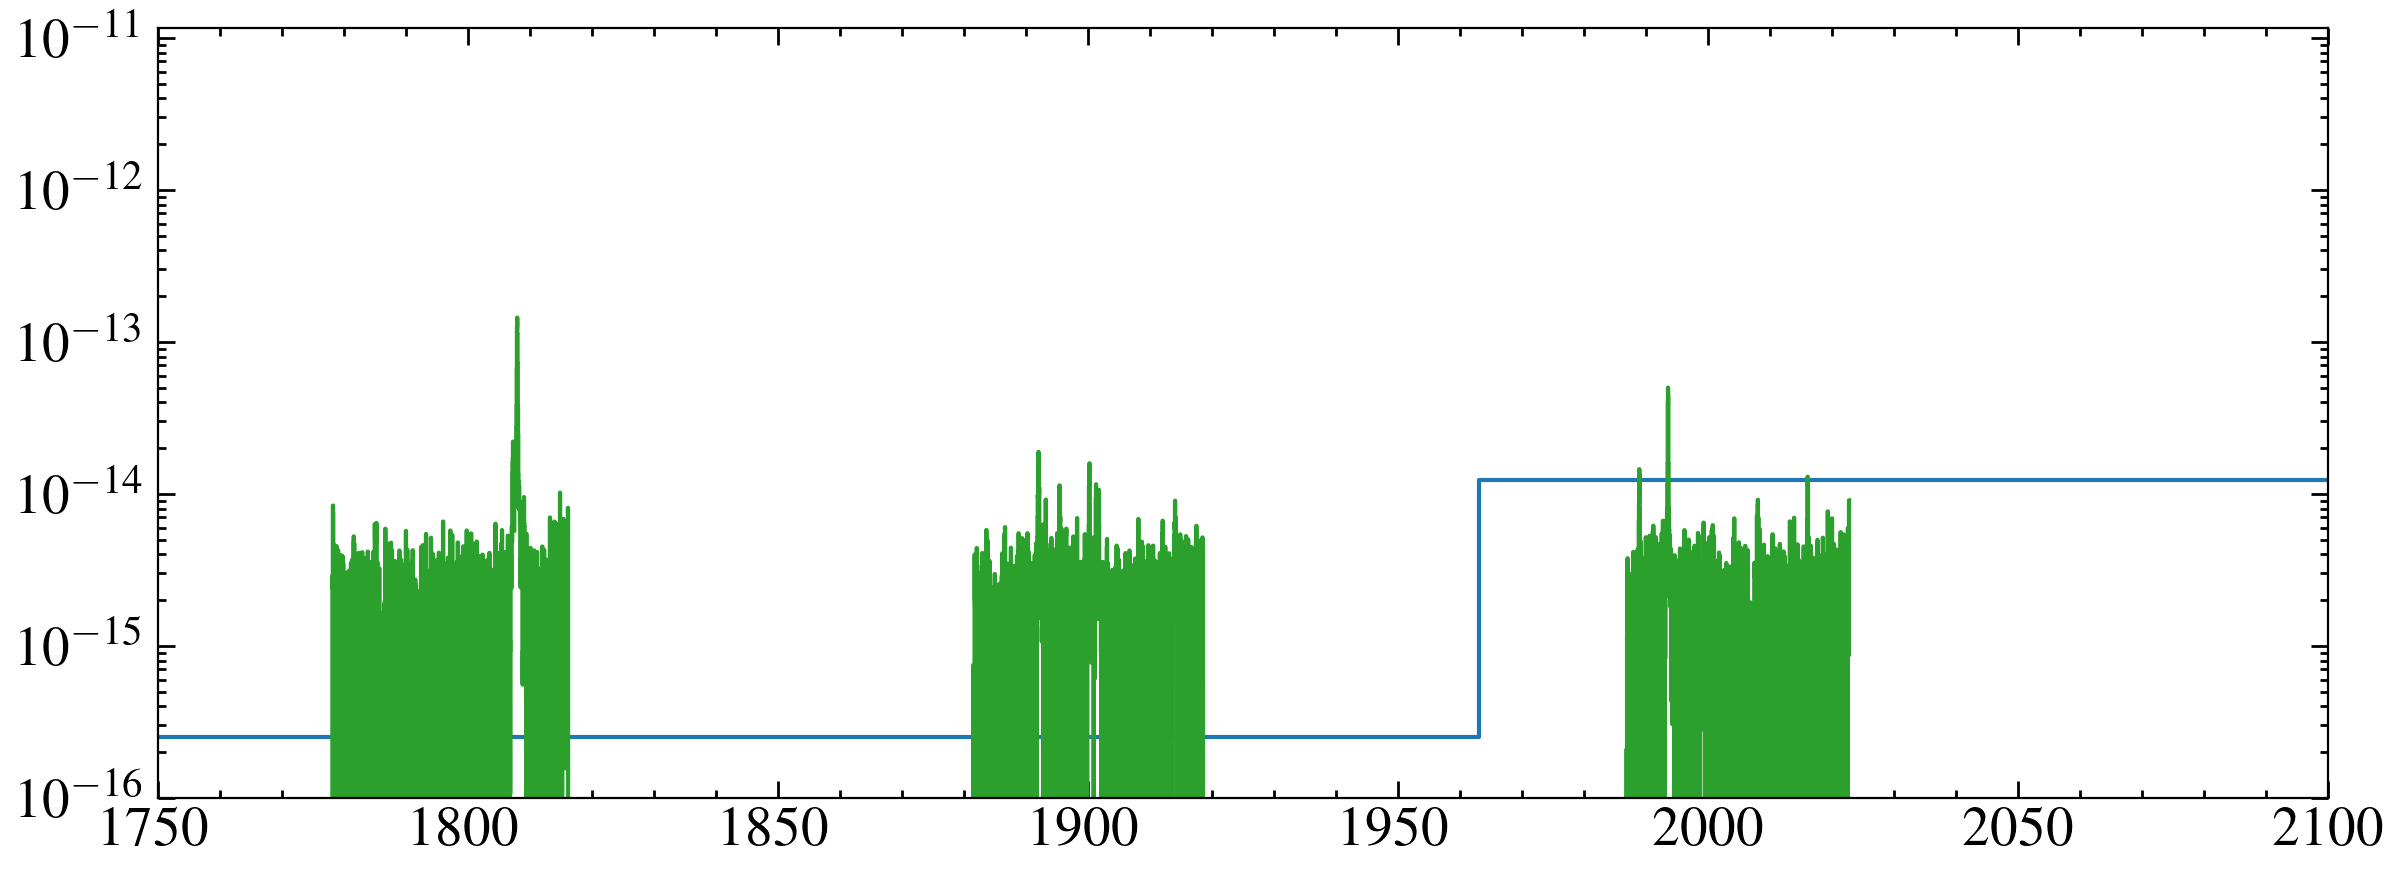

In [4]:
cspecs = glob.glob('{}hst/cspecs/*cspec.fits'.format(path))

fig, ax = plt.subplots()
for x in cspecs:
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ax.step(w, f, where='mid')
    print(w[0], w[-1])

# g185mpath = '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cos/lf7111010_x1dsum.fits'
# g185m = fits.getdata(g185mpath, 1)
# for data in g185m:
#     # data = fits.getdata(x, 1)
#     w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     f = convolve(f, kernel=Box1DKernel(5))
#     ax.step(w, f, where='mid')

ax.set_yscale('log')
ax.set_ylim(1e-16)

ax.set_xlim(1750, 2100)

Why did HASP not include the G185M spectrum? Fixed. Might need to write a little HASP to MUSCLES routine

Lots of gaps but clearly detected continuumn, might have to fit something. Nope, it has been done!

In [5]:
contpath = '{}cont/UVcont_estimate_YZCMi_080525.txt'.format(path)
cont = Table.read(contpath, format='csv')
cont.dtype.names

('Wave', 'Cont Flux', 'Cont Err', 'Conf Fit')

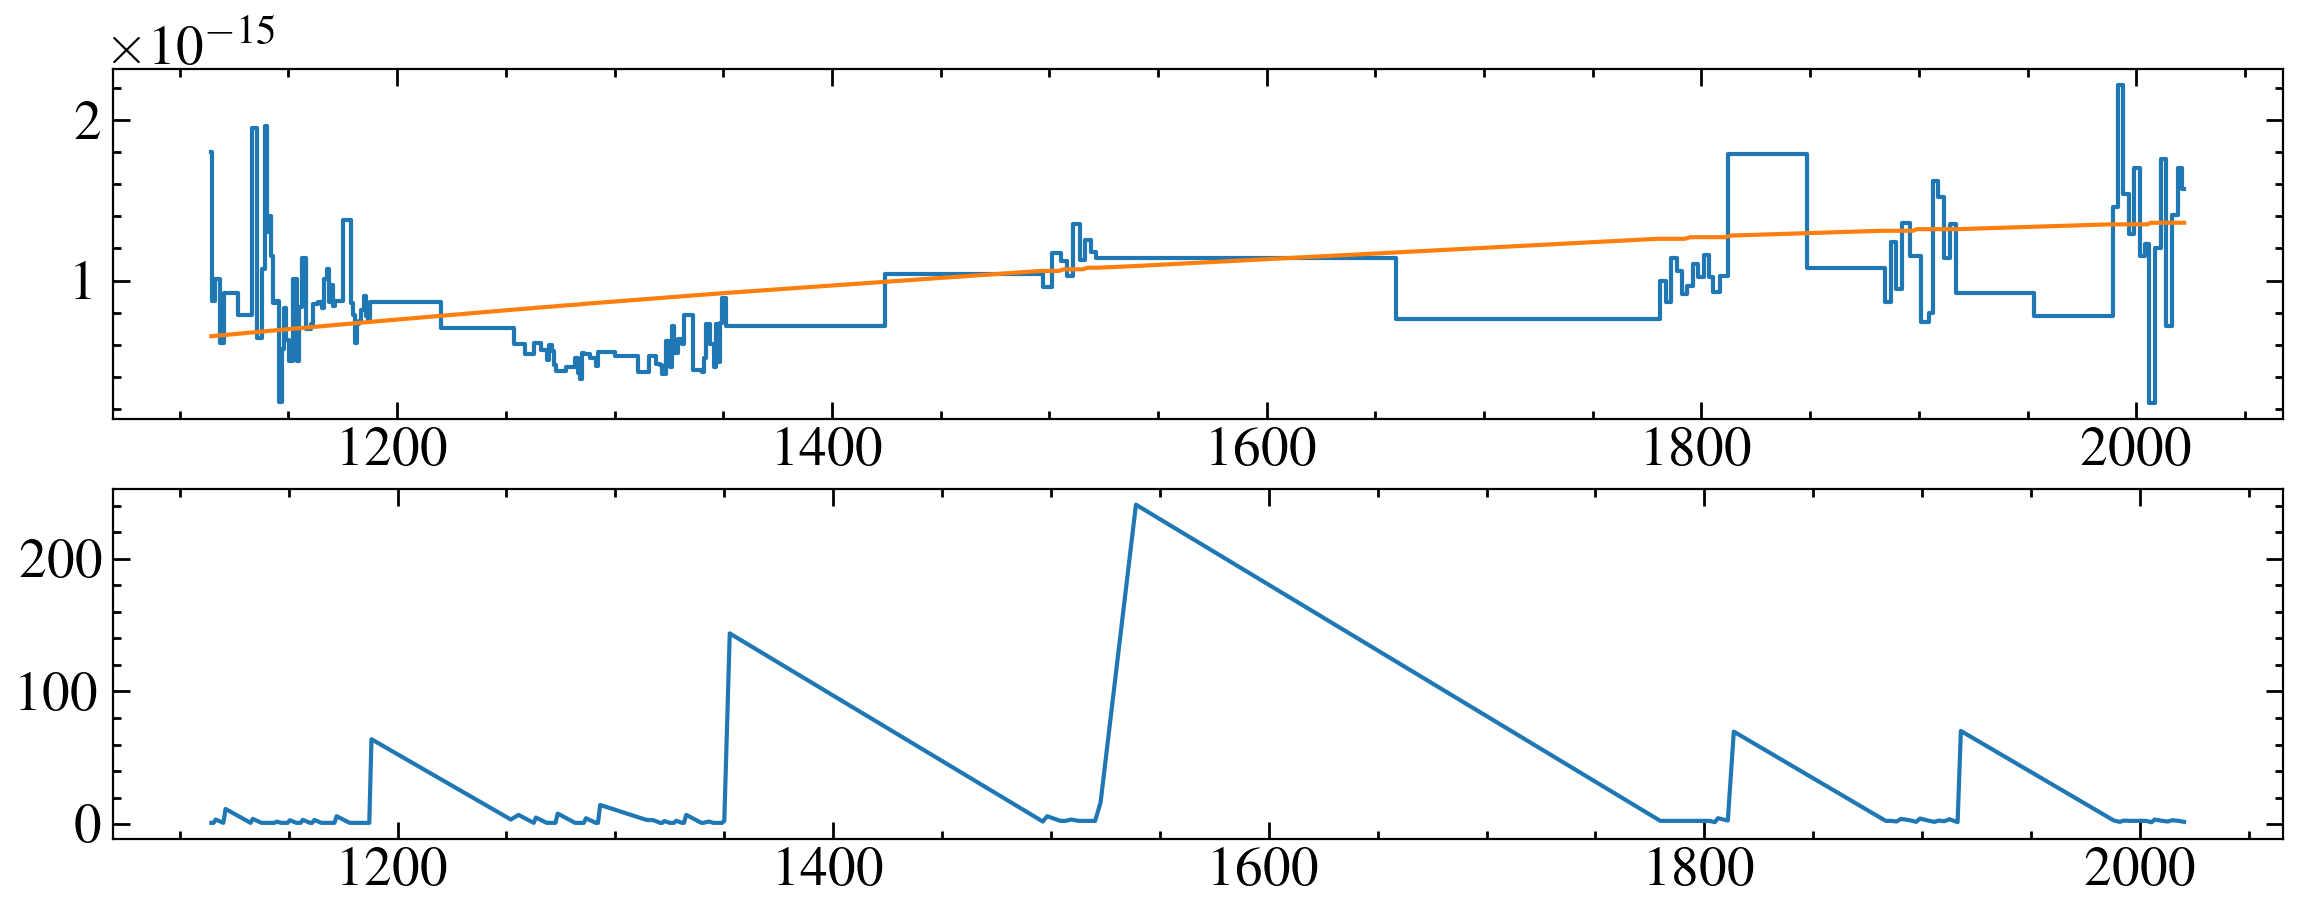

In [6]:
fig, ax = plt.subplots(nrows=2)
ax[0].step(cont['Wave'], cont['Cont Flux'], where='mid')
ax[0].plot(cont['Wave'], cont['Conf Fit'])

ax[1].plot(cont['Wave'][:-1], np.diff(cont['Wave']))

Need to extend cont out to 2300, do it with a flat line for now.

(1e-16, np.float64(1.1661496038735405e-11))

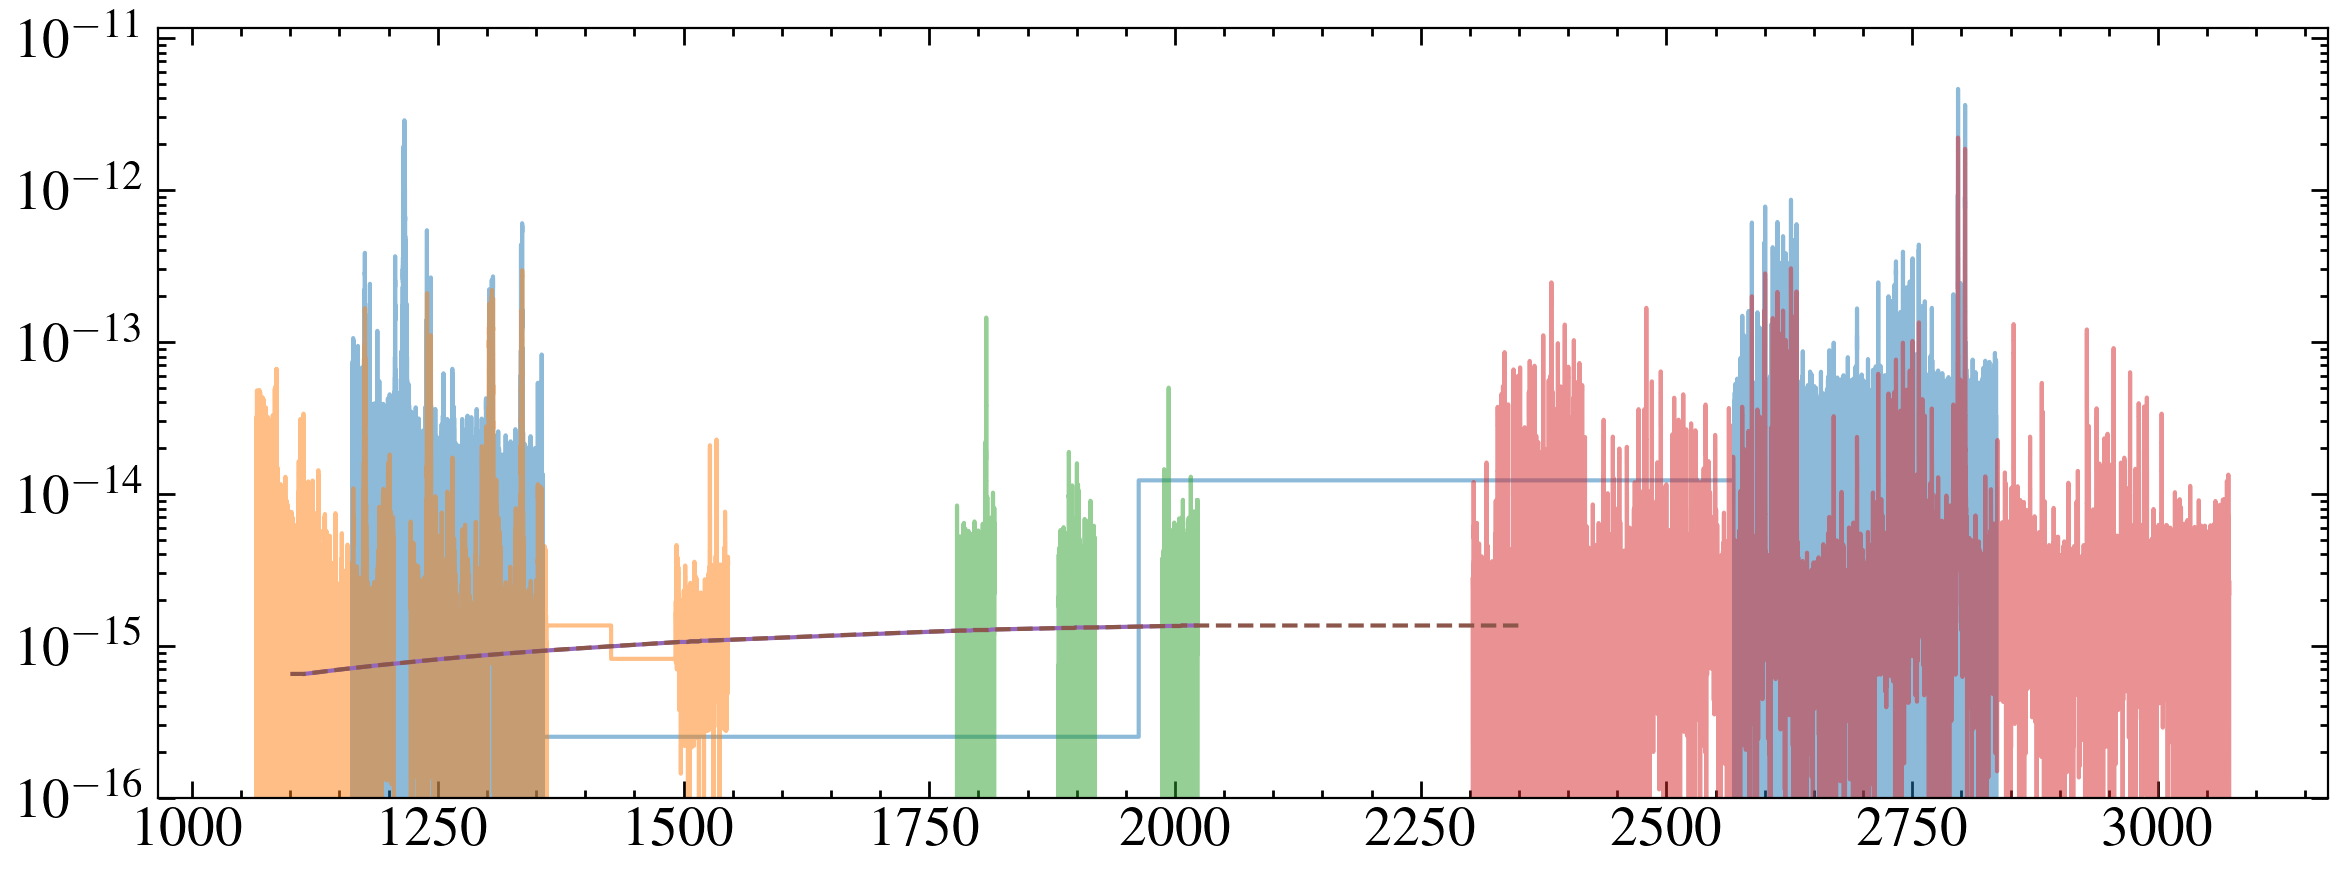

In [7]:

fig, ax = plt.subplots()
for x in cspecs:
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ax.step(w, f, where='mid', alpha=0.5)
    # print(w[0])

# g185mpath = '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cos/lf7111010_x1dsum.fits'
# g185m = fits.getdata(g185mpath, 1)
# for data in g185m:
#     # data = fits.getdata(x, 1)
#     w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     f = convolve(f, kernel=Box1DKernel(5))
#     ax.step(w, f, where='mid')

ax.plot(cont['Wave'], cont['Conf Fit'])
cw = np.arange(1100, 2351, 1)
cf = np.interp(cw, cont['Wave'], cont['Conf Fit'])
ax.plot(cw, cf, ls='--')


ax.set_yscale('log')
ax.set_ylim(1e-16)

# ax.set_xlim(1750, 2100)
# ax.set_xlim(1290, 1300)

Ok that works. Use the COS + G230M data, higher S/N. Could also use Kevin's line list?

In [8]:
lines = Table.read('{}cont/DEM_goodlinelist_YZCMi.csv'.format(path))
# lines = lines[lines['Flux'] != 0.0]
lines = lines[lines['Flux'] > 0.0]
lines

Ion,Wavelength,Likelihood to measure,Log Formation Temperature,col4,Flux,Flux_Err
str6,float64,str6,float64,int64,float64,float64
Fe XIX,1118.057,Low,6.9,--,2.45e-15,5.15e-16
Ne V,1145.596,Medium,5.5,--,1.02e-15,3.18e-16
C III,1175.713,High,4.9,--,1.37e-13,2.51e-15
N V,1238.821,High,5.3,--,6.21e-14,5.2e-16
N V,1242.804,High,5.3,--,3.16e-14,4.4e-16
S II,1253.811,Medium,4.5,--,1.25e-15,4.61e-17
S II,1259.519,Medium,4.5,--,1.66e-15,8.31e-17
Si II,1260.417,Medium,4.5,--,2.1e-15,6.8e-17
Si II,1264.737,High,4.5,--,4.53e-15,1.07e-16


(-1e-14, 1e-13)

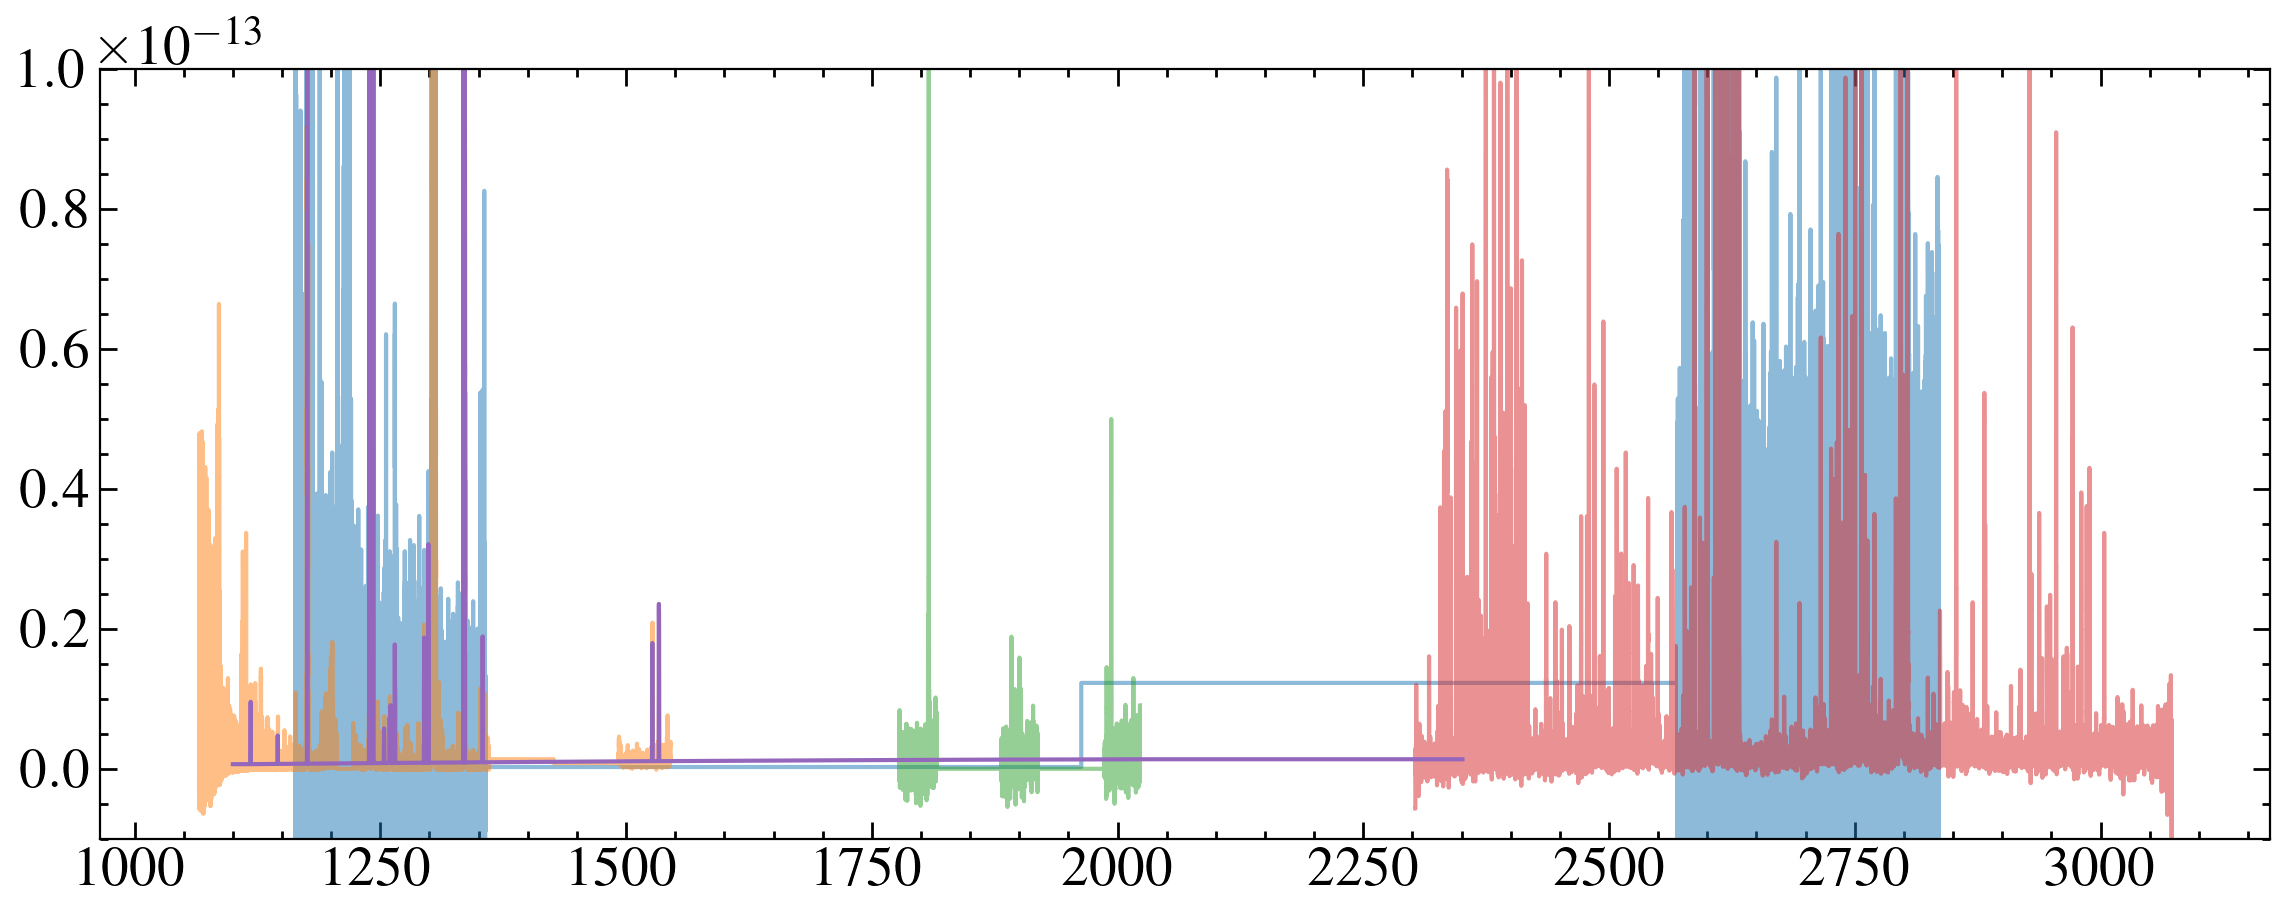

In [9]:
fig, ax = plt.subplots()


for x in cspecs:
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ax.step(w, f, where='mid', alpha=0.5)

std = 0.1
cw = np.arange(1100, 2351, 0.1)
cf = np.interp(cw, cont['Wave'], cont['Conf Fit'])
for line in lines:
    wline = line['Wavelength']
    fline = line['Flux']
    eline = line['Flux_Err']

    amp = fline / (std * (2* np.pi)**0.5)
    mod = models.Gaussian1D(amp, wline, std)
    mod = mod(cw)

    cf += mod

ax.plot(cw, cf)
# ax.set_xlim(1220, 2000)
# ax.set_xlim(1270, 1300)
# ax.set_xlim(1500, 1550)
ax.set_ylim(-1e-14, 1e-13)

(0.0, 1e-14)

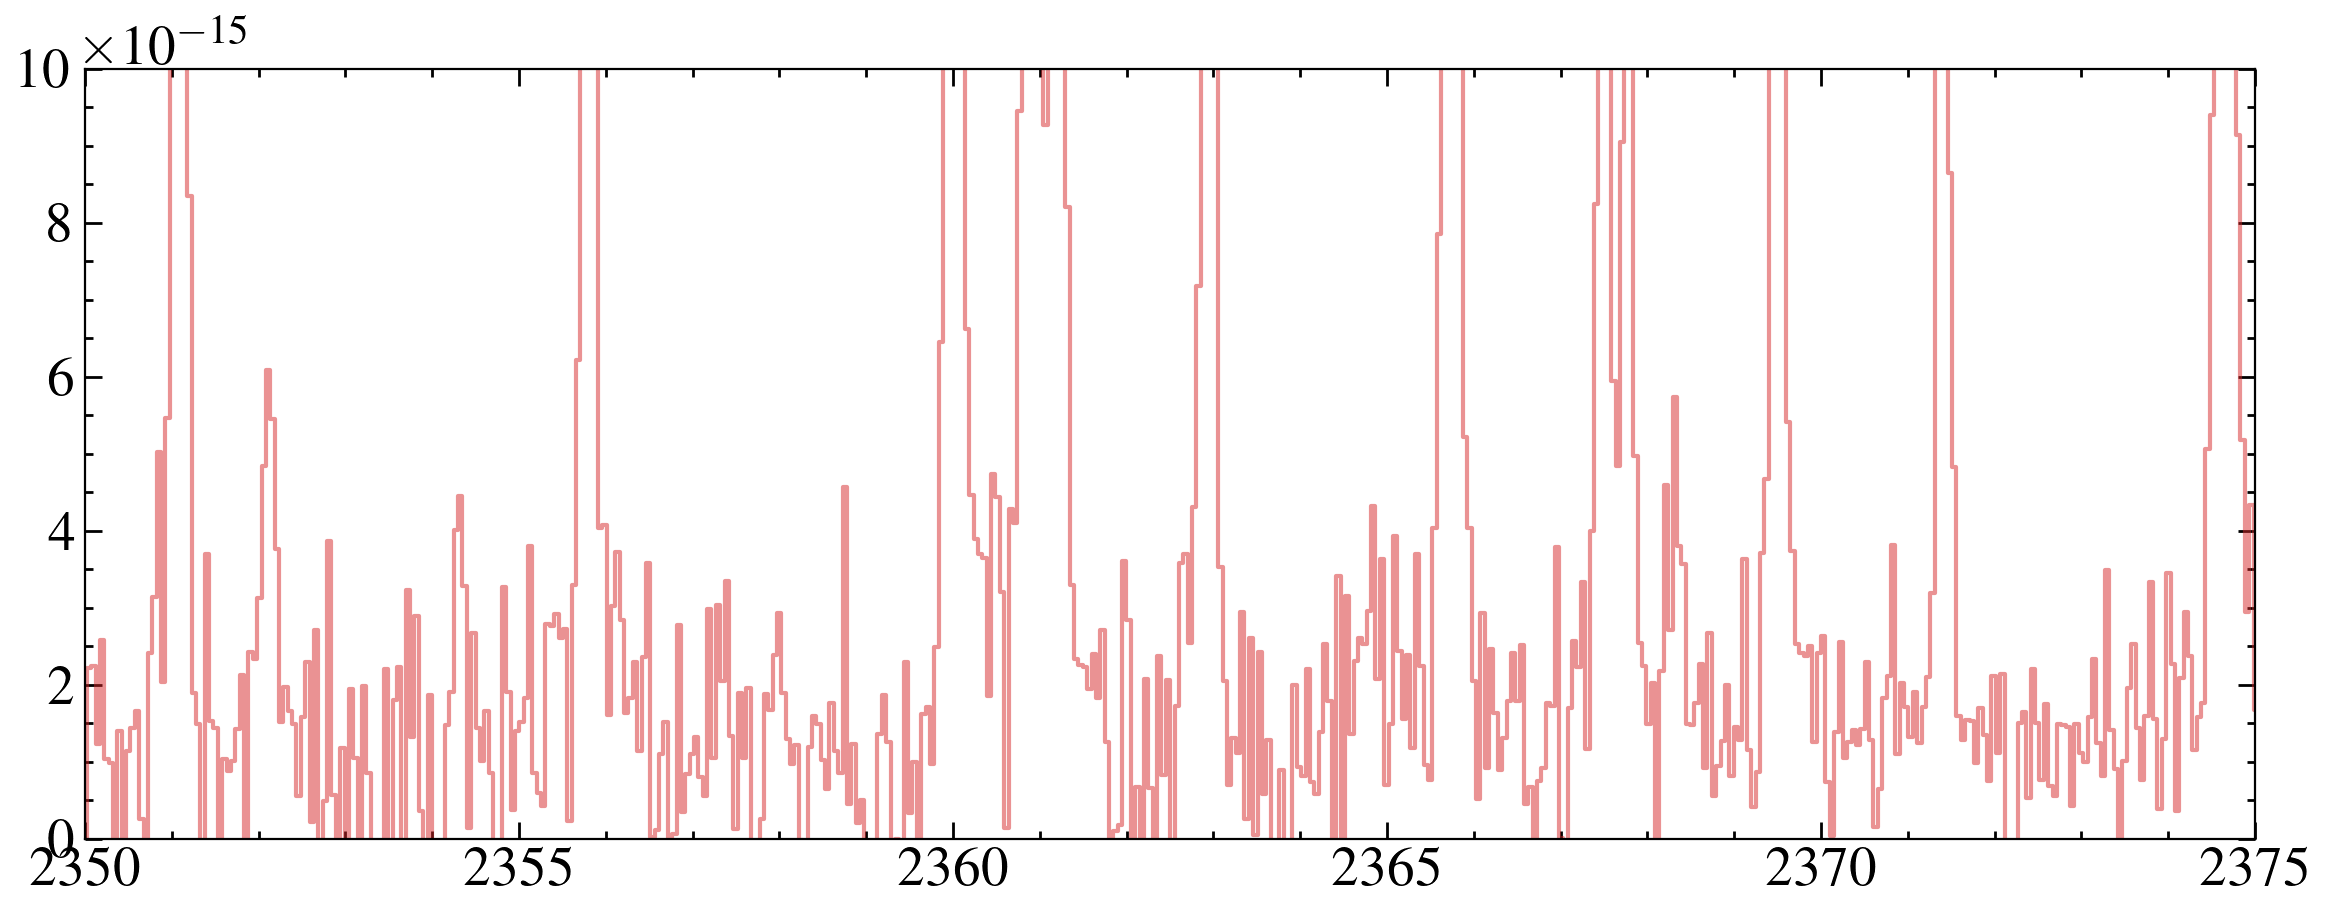

In [10]:
fig, ax = plt.subplots()


for x in cspecs:
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ax.step(w, f, where='mid', alpha=0.5)

ax.set_xlim(2350, 2375)
ax.set_ylim(0, 0.1e-13)

Draft HASP to MUSCLES, add Lya, add DEM, convert RGS spectrum to flux, grab and check PHX, combine! I can just write an add_hasp routine

['CHANNEL', 'FLUX', 'ERROR']


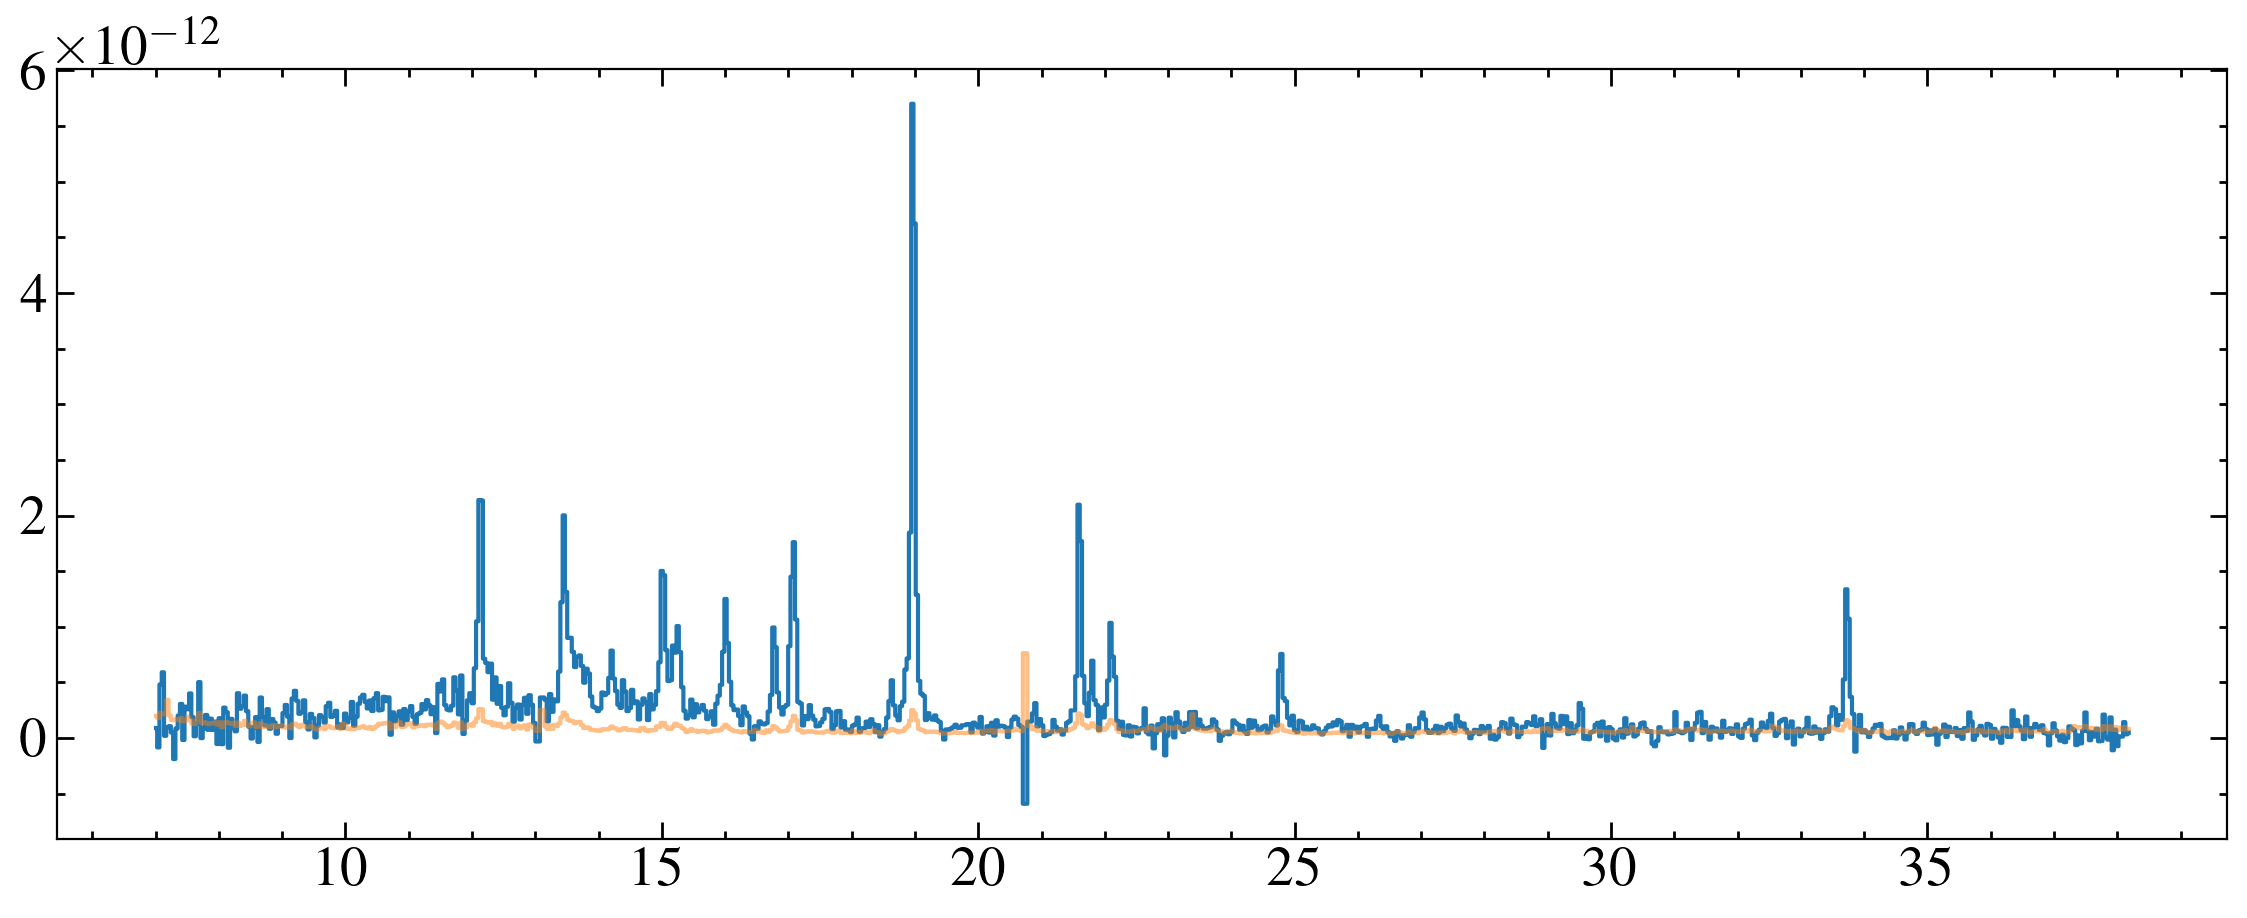

In [12]:
xpath = '{}/xmm/'.format(path)
xname = 'P0111460101RGX000FLUXED1003.fits'
xdata = fits.getdata('{}{}'.format(xpath, xname), 1)
print(xdata.names)
#CHANNEL is actually the wavelength array in AA
# fits.getheader('{}{}'.format(xpath, xname), 1)

xw, xc, xce = xdata['CHANNEL']*u.AA, xdata['FLUX']*u.ph/u.s/u.cm**2/u.AA, xdata['ERROR']*u.ph/u.s/u.cm**2/u.AA
mask = ~np.isnan(xc.value) & (xw > 7*u.AA)
xw, xc, xce = xw[mask], xc[mask], xce[mask]
xf = xc.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(xw))
xe = xce.to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(xw))

fig, ax = plt.subplots()

ax.step(xw, xf, where='mid')
ax.step(xw, xe, where='mid', alpha=0.5)

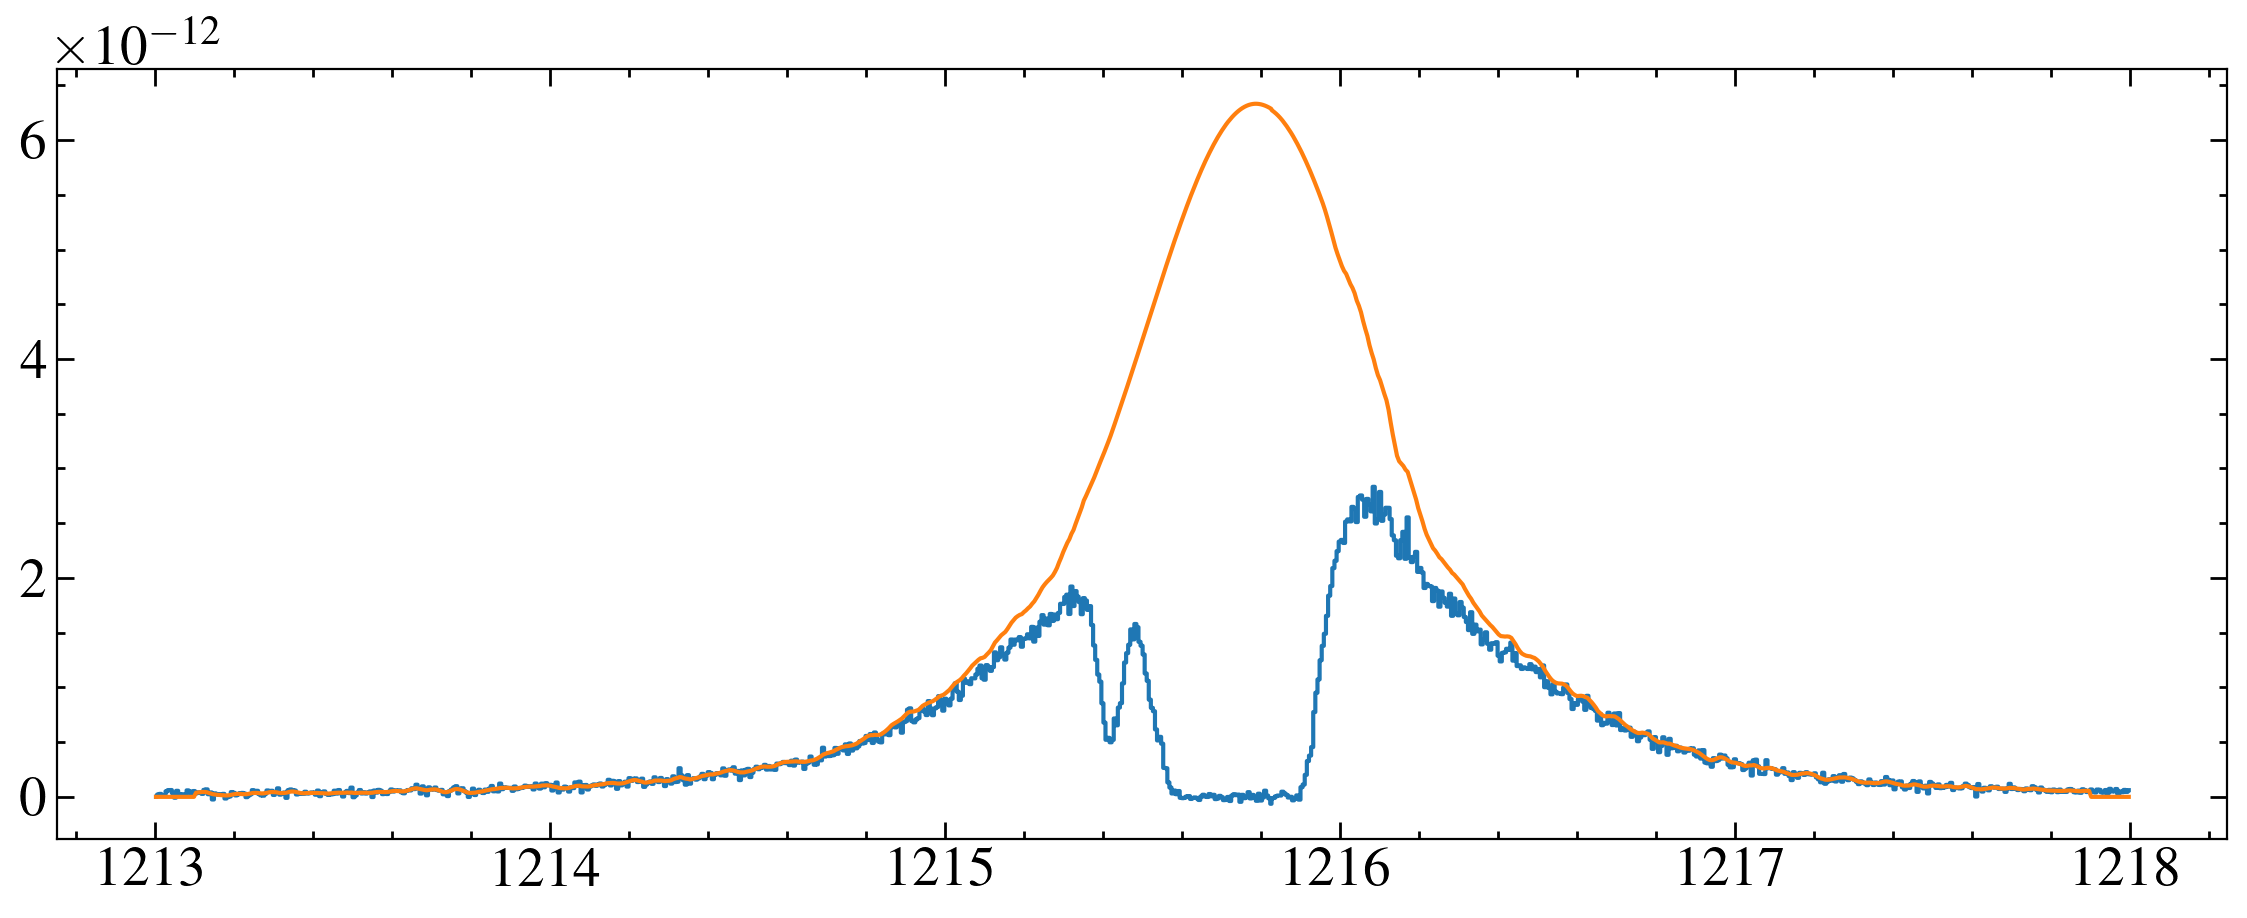

In [13]:
lyapath = '{}lya/yzcmi_e140h.txt'.format(path)
lya = Table.read(lyapath, format='ascii.basic')
# lya.dtype.names

fig, ax = plt.subplots()

ax.step(lya['WAVELENGTH'], lya['FLUX'], where='mid')
ax.plot(lya['WAVELENGTH'], lya['MODEL'])

lw, lf, le = lya['WAVELENGTH'], lya['MODEL'], lya['MODEL']*0.1

Should I measure and add more lines from the G185 spectrum?

In [14]:
cspecs

['/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cspecs/hst_15326_stis_gj285_e140h-e230h_odhy_cspec.fits',
 '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cspecs/hst_17428_cos-stis_v-yz-cmi_g130m-g140m_lf71_cspec.fits',
 '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cspecs/hst_17428_cos_v-yz-cmi_g185m_lf71_cspec.fits',
 '/media/david/2tb_ext_hd/hddata/yz_cmi/hst/cspecs/hst_8129_stis_yzcmi_e230m_o59k_cspec.fits']

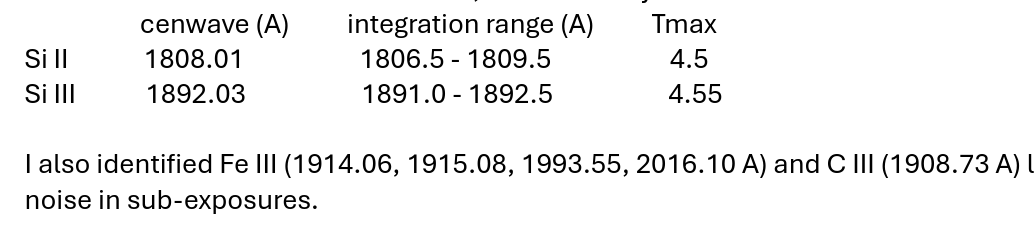

0.05573674314390125
2.3313871487890083e-14 2.3321787203424905e-14 0.9996605870954153
4.09559558573468e-15 4.064781176951925e-15 1.0075808284483994
1.9231704488068502e-15 1.9426592158095062e-15 0.989967994981284
3.3447890199195244e-16 3.7906338866460726e-16 0.8823825038083463
7.564946112372739e-16 7.63551622683114e-16 0.9907576498612605
6.483392545557626e-15 6.4917950639139945e-15 0.998705671039575
1.793091084000956e-15 1.8488221143097037e-15 0.9698559261719152


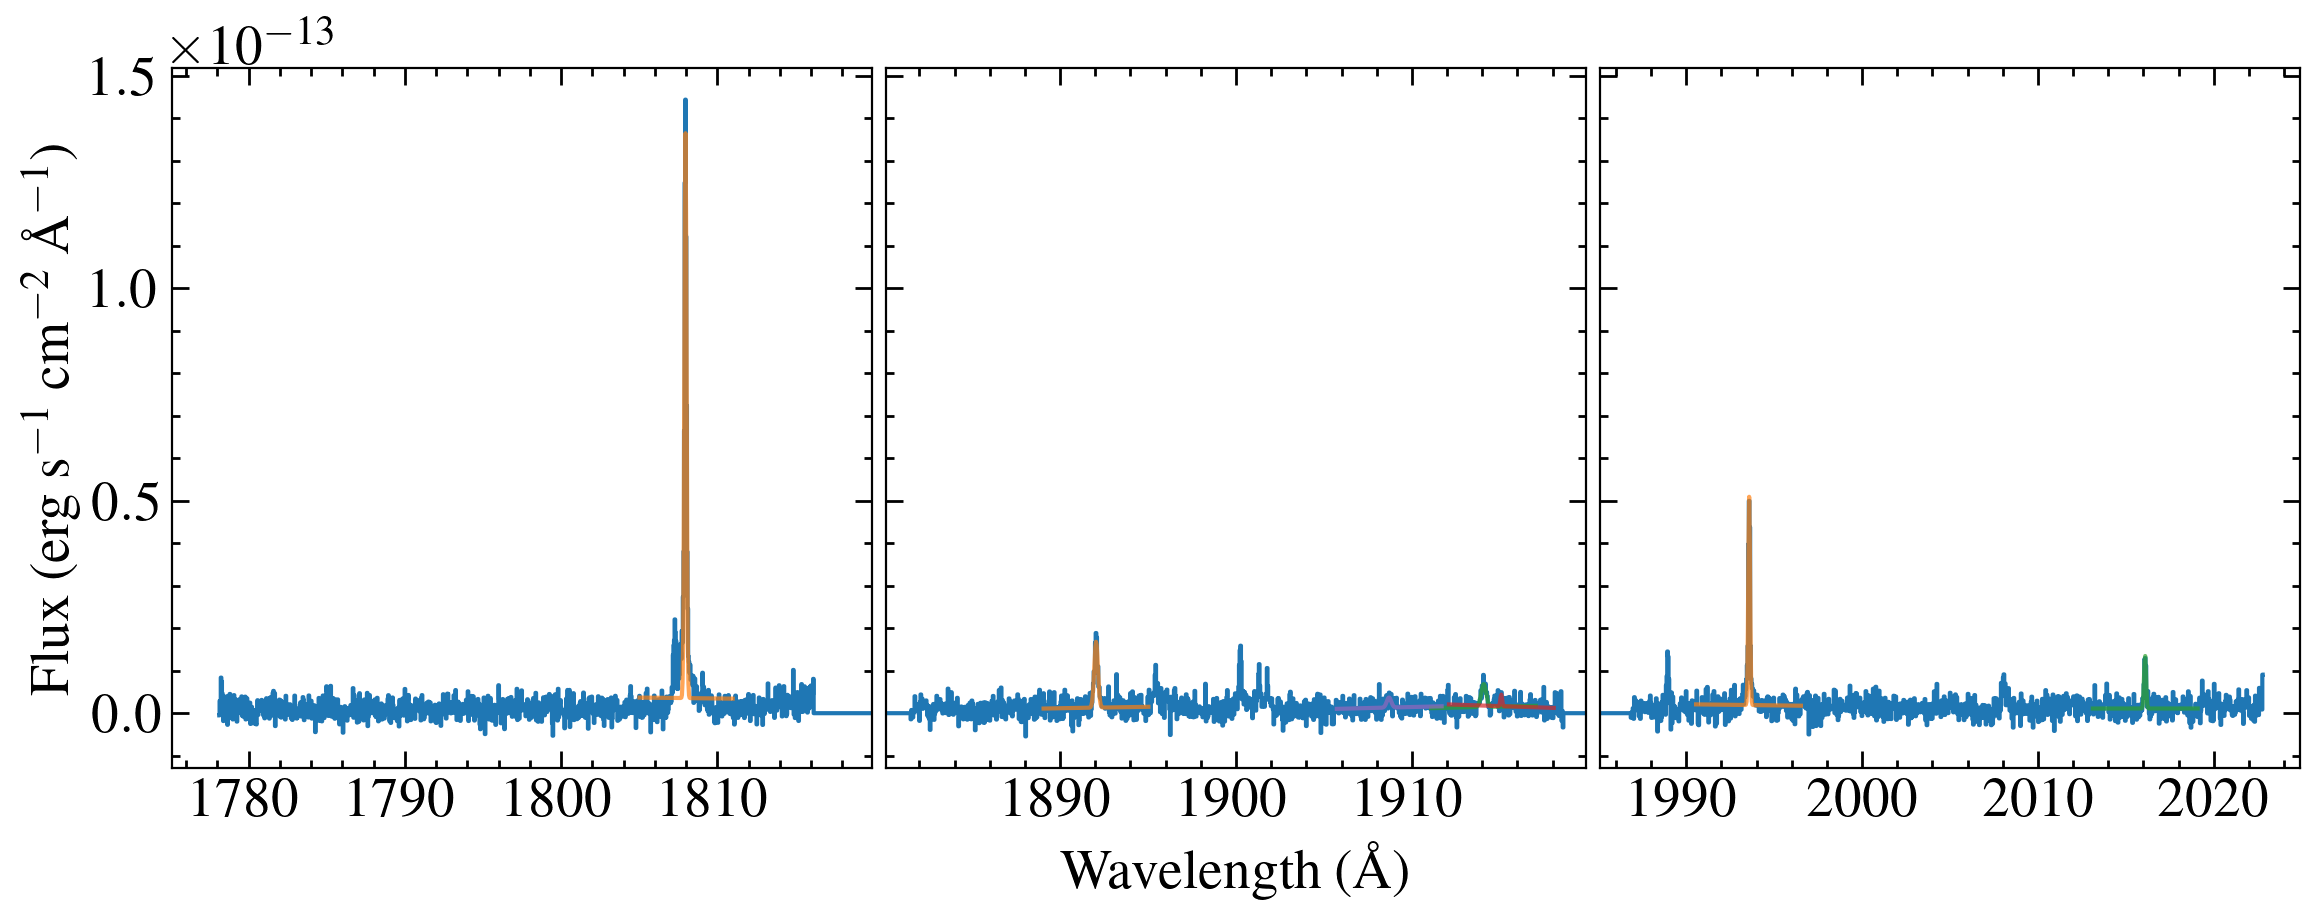

In [17]:
cspecs = glob.glob('{}hst/cspecs/*cspec.fits'.format(path))

bands = [[1775.1,1819.9], [1880.1, 1919.9], [1985.1, 2024.9]]

scale = 1e13

si2 = [1808.01]
si3 = [1892.03]
fe3 = [1914.06, 1915.08, 1993.55, 2016.10]
c3 = [1908.73]

glines = np.hstack((si2, si3, fe3, c3))

fig, axes = plt.subplots(ncols =3, sharey=True, figsize=(12, 5))
data = fits.getdata(cspecs[2], 1)[0]
w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']

lineband = 3
FWHM = 2100/16000
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
print(sigma)
fitter = fitting.LevMarLSQFitter(calc_uncertainties=True)

g185m_line_fluxes = []

for i, band in enumerate(bands):

    axes[i].step(w, f, where='mid')
    axes[i].set_xlim(band[0], band[1])

    for line in glines:
        if (line > band[0]) & (line < band[1]):
            mask = (w > line-lineband) & (w < line + lineband)
            wfit, ffit, efit = w[mask], f[mask], e[mask]
            # mod_init = models.Gaussian1D(1e-15, line, sigma, fixed=dict(stddev=True))+models.Polynomial1D(1)
            mod_init = models.Gaussian1D(max(ffit), line, sigma)+models.Polynomial1D(1)
            mod_fit = fitter(mod_init, wfit, ffit) 
            axes[i].plot(wfit, mod_fit(wfit), alpha=0.7)
            mod_flux = (mod_fit[0].amplitude * mod_fit[0].stddev * (2* np.pi)**0.5)
            int_flux = np.trapezoid(ffit, wfit) - np.trapezoid(mod_fit[1](wfit), wfit)
            print(mod_flux, int_flux, mod_flux/int_flux)
            g185m_line_fluxes.append(mod_flux)
            # amp = fline / (std * (2* np.pi)**0.5)

axes[1].set_xlabel(r'Wavelength (\AA)', size=20)
# axes[0].set_ylabel(r'Flux (10$^{-13}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
axes[0].set_ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
axes[0].set_xticks([1780, 1790, 1800, 1810])

fig.tight_layout()
fig.subplots_adjust(wspace=0.02)

g185m_lines, g185m_line_fluxes = glines, np.array(g185m_line_fluxes)


# ax.set_xlim(1750, 2100)
# fig.savefig('plots/yzcmi_g185m.pdf')

(-1e-14, 1e-13)

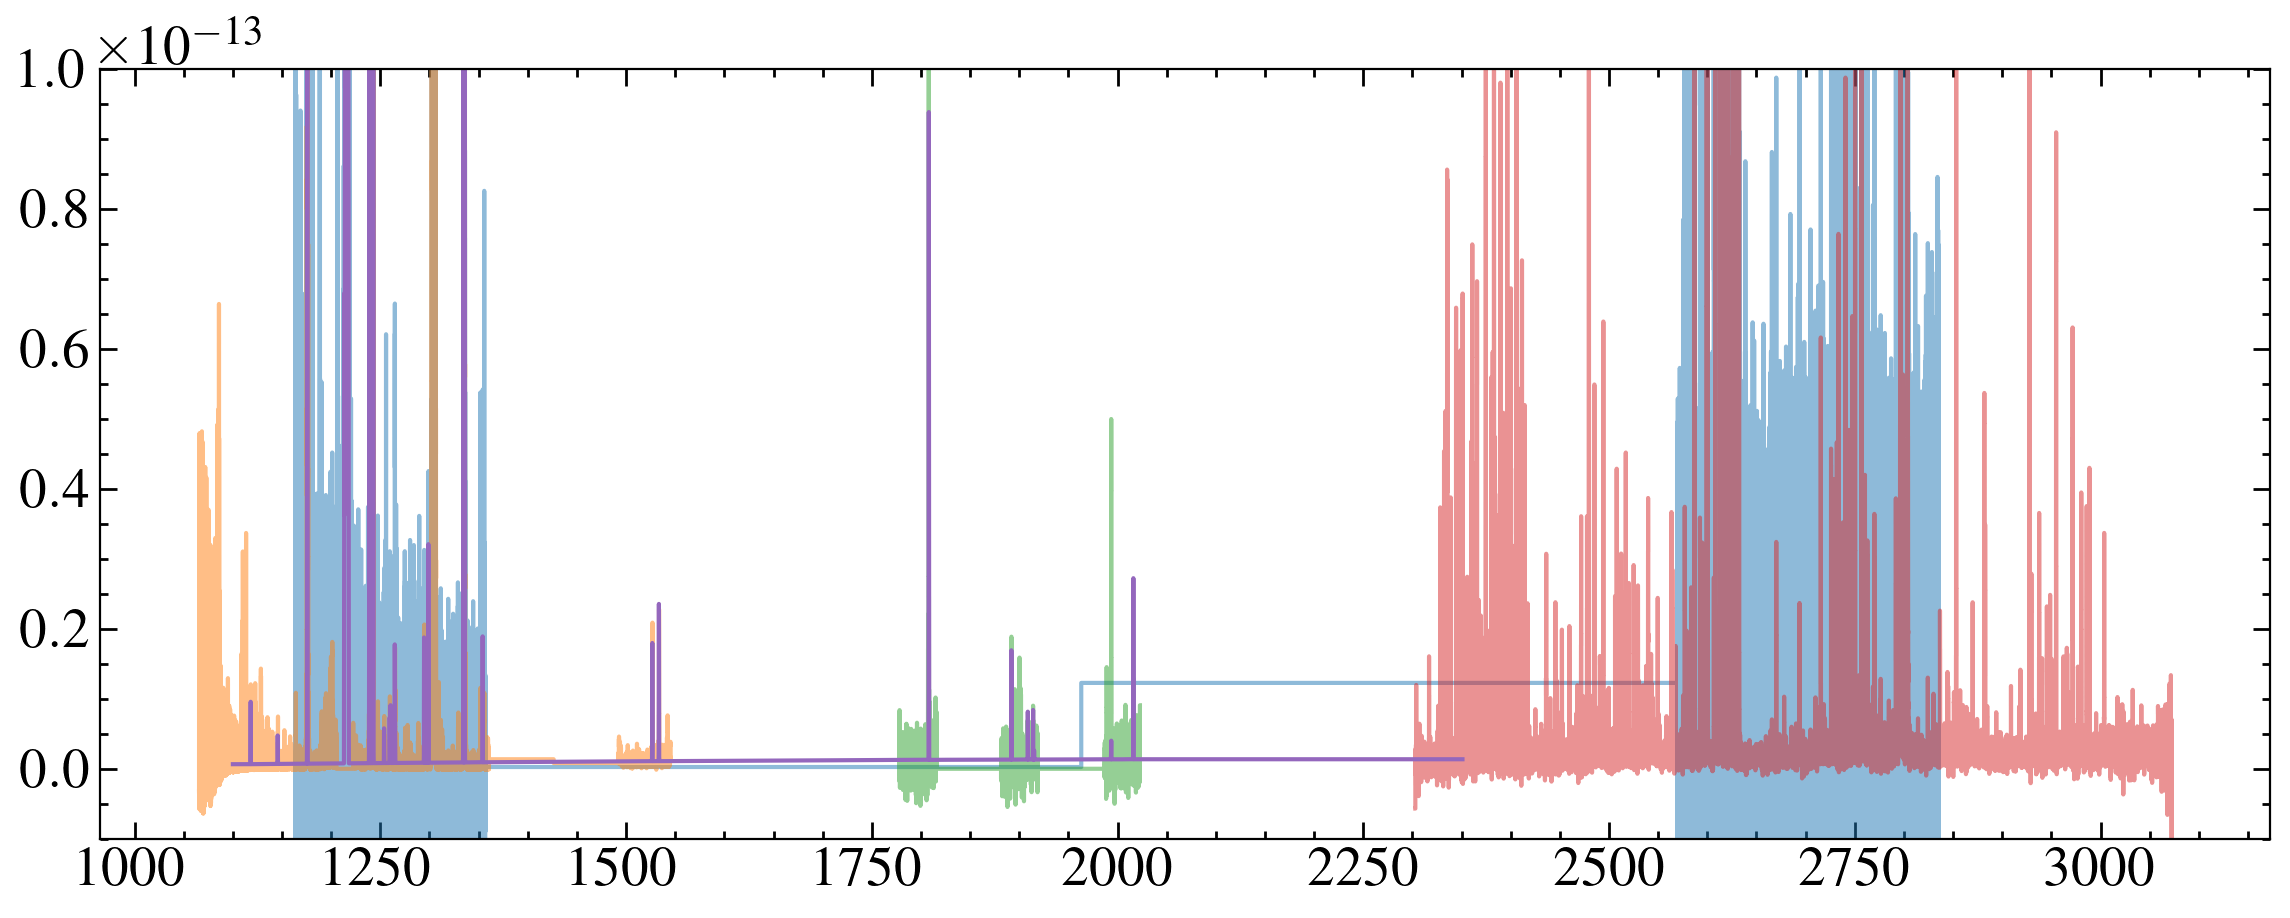

In [18]:
fig, ax = plt.subplots()


for x in cspecs:
    data = fits.getdata(x, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    ax.step(w, f, where='mid', alpha=0.5)

std = 0.1
cw = np.arange(1100, 2351, 0.1)
cf = np.interp(cw, cont['Wave'], cont['Conf Fit'])
for line in lines:
    wline = line['Wavelength']
    fline = line['Flux']
    eline = line['Flux_Err']

    amp = fline / (std * (2* np.pi)**0.5)
    mod = models.Gaussian1D(amp, wline, std)
    mod = mod(cw)

    cf += mod

for wline, fline in zip(g185m_lines, g185m_line_fluxes):
    amp = fline / (std * (2* np.pi)**0.5)
    mod = models.Gaussian1D(amp, wline, std)
    mod = mod(cw)

    cf += mod

lfi = np.interp(cw, lw, lf, left=0.0, right = 0.0)
cf += lfi

ax.plot(cw, cf)
# ax.set_xlim(1220, 2000)
# ax.set_xlim(1270, 1300)
# ax.set_xlim(1500, 1550)
ax.set_ylim(-1e-14, 1e-13)

Would like to use the E230M spectrum, but should compare with the much later E230H spectrum first

In [19]:
def guass_smooth(wavelength, flux, A = 'none', R='none', Lambda = 'none', return_meta=False):
    """
    Takes a spectrum and Guassian smooths it either to a angstroms per resel A or an R value. If the wavelength Lambda at which R is evaluated is not supplied it takes the central wavelength of the spectrum.   
    """  
    respix = (wavelength[-1] - wavelength[0])/len(wavelength)
    if A == 'none':
        try: 
            R != 'none'
        except:
            print('Error: I need either an Angstroms per resolution element A or a resolution R = Lambda/A')
            return
        if Lambda == 'none':
            Lambda = (wavelength[-1] + wavelength[0])/2 #mid point of spectrum
        A = Lambda / R
    FWHM = A/respix 
    sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
    f_smooth = convolve(flux, Gaussian1DKernel(sigma))
    if return_meta:
        meta = dict(A = A, R = R, Lambda=Lambda, FWHM = FWHM, ResPix= respix)
        return f_smooth, meta
    else:
        return f_smooth

2302.9382 3072.4956
2569.2244 2835.3616
[5.29372824e-13 4.34514566e-13]
[8.26930430e-13 6.62392721e-13]
[1.5620946  1.52444307]


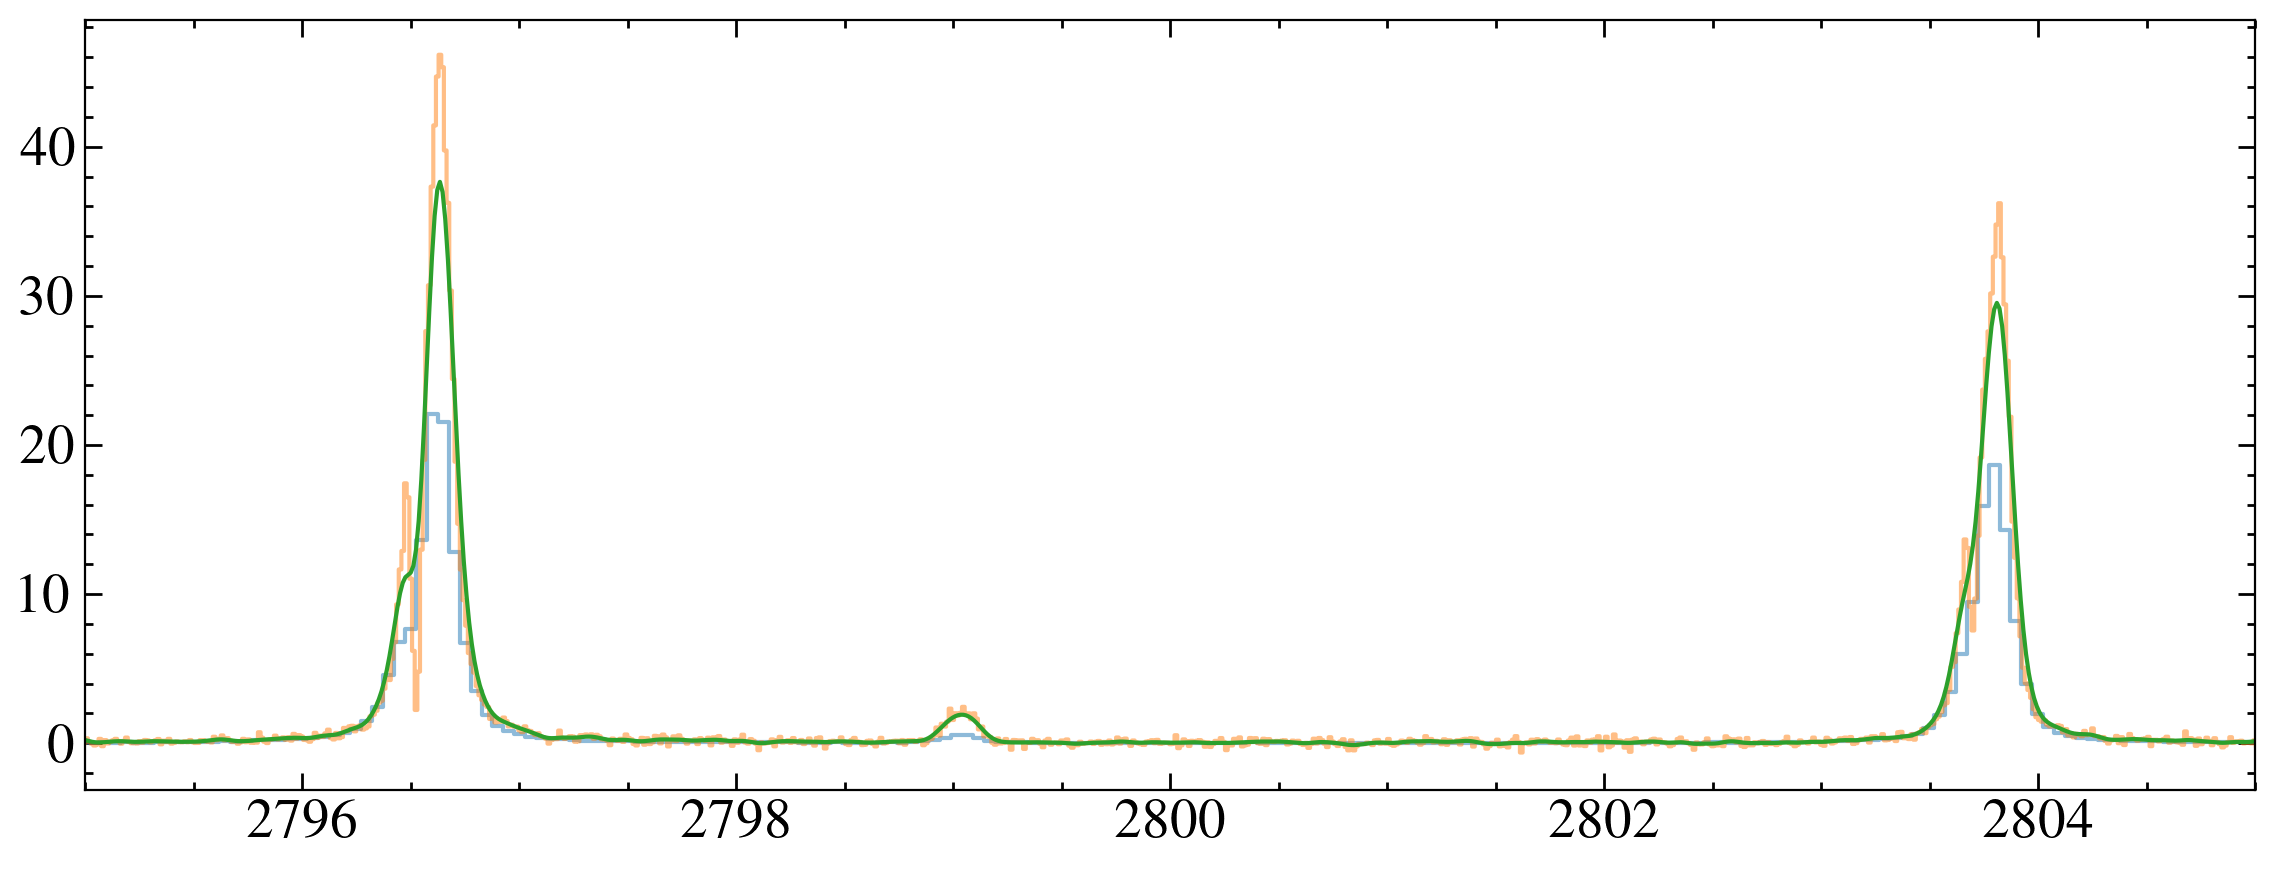

In [20]:
nuvspecs = ['{}hst/stis/hst_8129_stis_yzcmi_e230m_o59k_cspec.fits'.format(path), '{}hst/stis/hst_15326_stis_gj285_e230h_odhy_cspec.fits'.format(path)]

scale = 1e13

fig, ax = plt.subplots()

mg2 = [2796.352, 2803.53]
mgfluxes = []

for i, spec in enumerate(nuvspecs):
    data = fits.getdata(spec, 1)[0]
    w, f, e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
    print(w[0], w[-1])
    ax.step(w, f*scale, where='mid', alpha=0.5)
    if i == 1:
        fsmooth = guass_smooth(w, f, R=30000)
        ax.plot(w, fsmooth*scale)

    for line in mg2:
        mask = (w > line-0.5) & (w < line+0.5)
        lineflux = np.trapezoid(f[mask], w[mask])
        mgfluxes.append(float(lineflux))

mgfluxes= np.array(mgfluxes)
ax.set_xlim(2795, 2805)

print(mgfluxes[0:2])
print(mgfluxes[2:4])
print(mgfluxes[2:4]/mgfluxes[0:2])



Well that's a problem. Use the E230M but with a caveat?

In [21]:
nuvspec = '{}hst/stis/hst_8129_stis_yzcmi_e230m_o59k_cspec.fits'.format(path)
data = fits.getdata(nuvspec, 1)[0]
nw, nf, ne = data['WAVELENGTH'], data['FLUX'], data['ERROR']

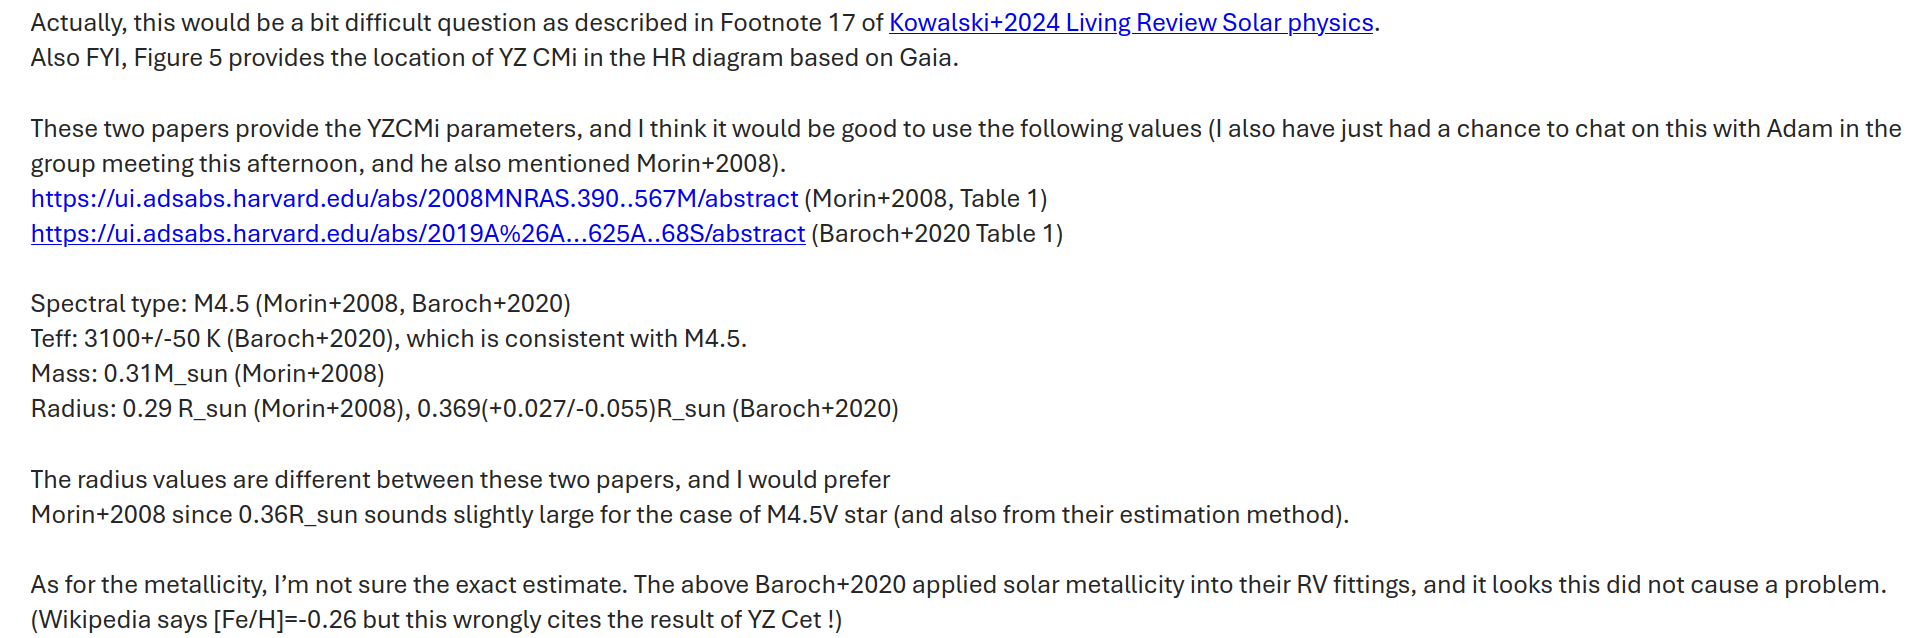

In [22]:
#Morin+2008

import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.31
teff = 3101
teff_e = 50

radius = 0.27
distance = 5.986320

save_path = 'models/'
star = 'yz_cmi'
g = np.log10(((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2).value)
print(g)
# g = 5.00
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
pw1, pf1, pe1 = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=False, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw1, pf1, pe1 = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac1 = ((radius*R)/((distance*u.pc).to(u.m)))**2

5.066701792819432


In [23]:
#Baroch+2020

import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
# mass = 0.31 #not quoted
teff = 3101
teff_e = 50

radius = 0.369
distance = 5.986320

save_path = 'models/'
star = 'yz_cmi'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 5.00
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=False, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

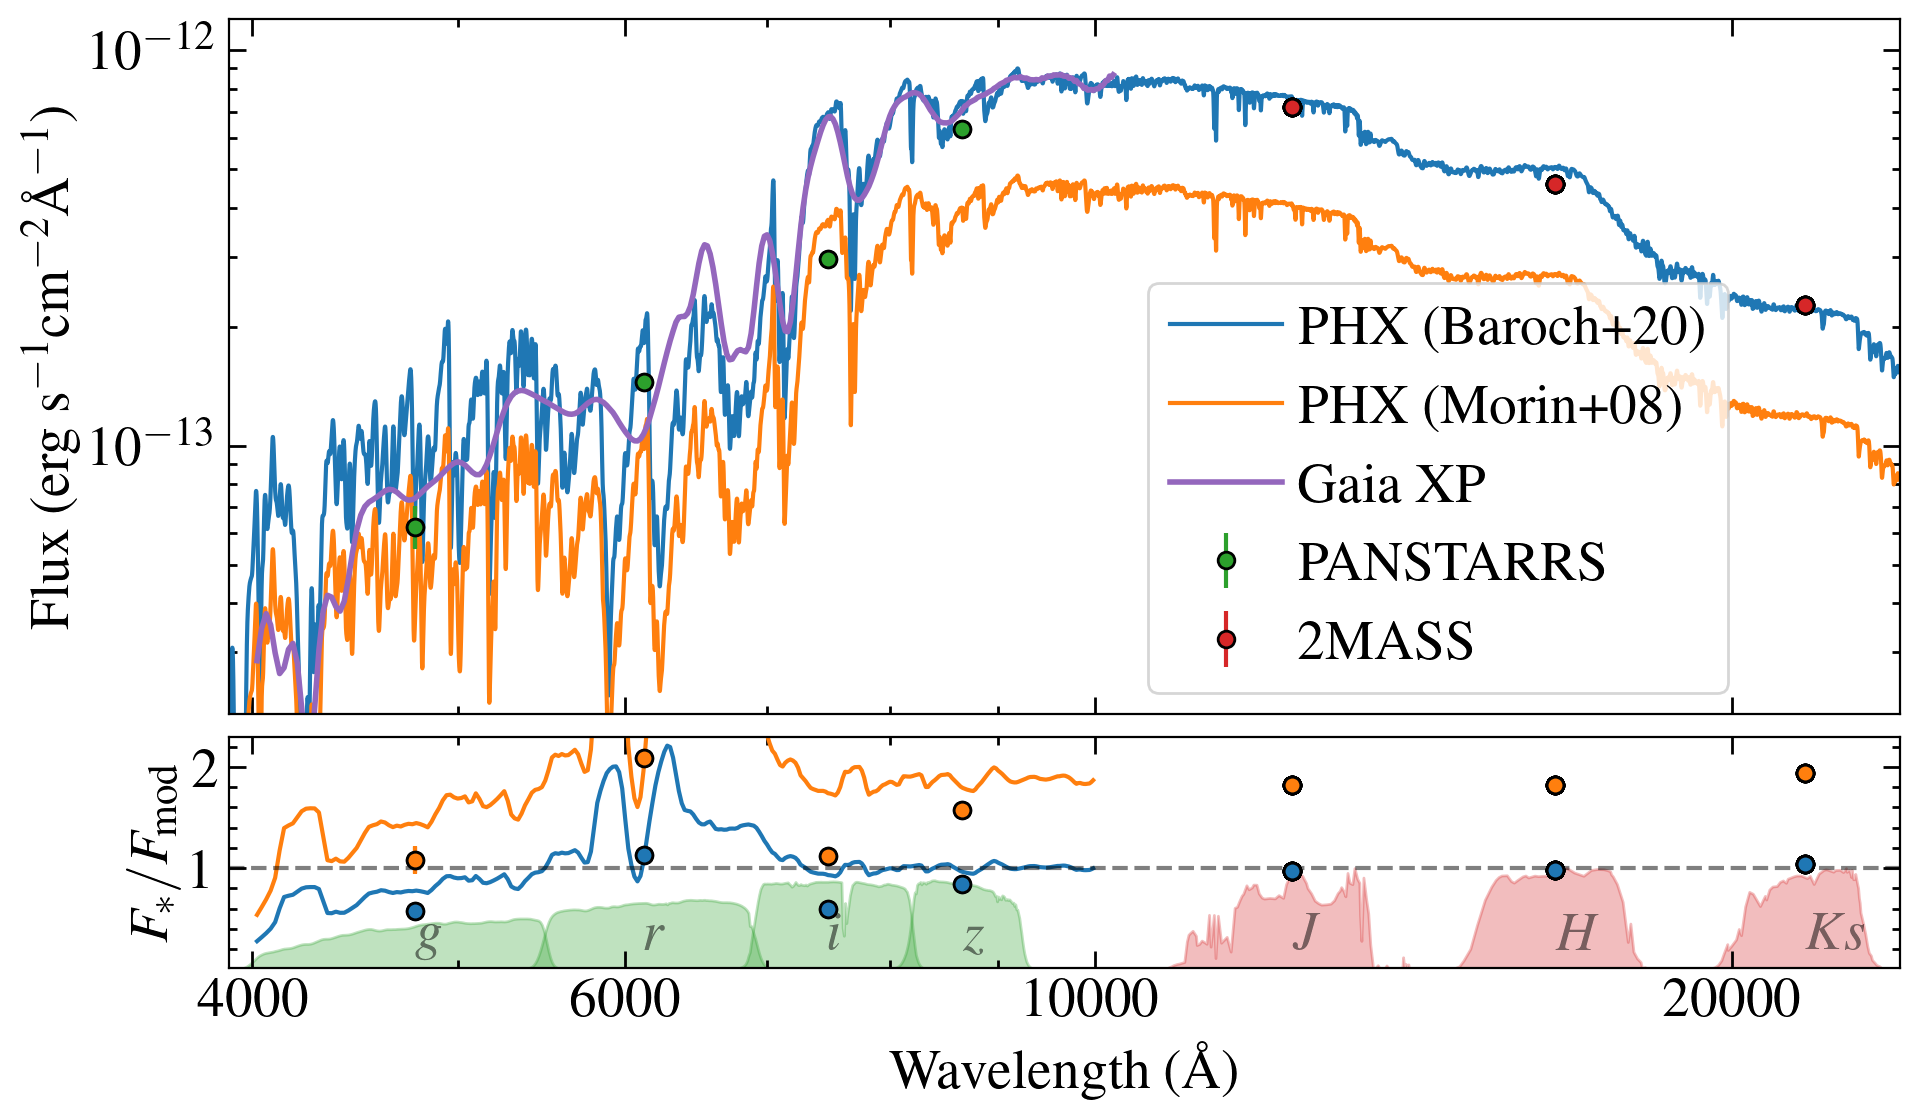

In [24]:
def make_phot(bp_w, bp_cc, w, f, e=0):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = np.interp(w, bp_w, bp_cc, left=0, right=0)
    flux = np.trapezoid(f*bb_cci, w)/np.trapezoid(bb_cci, w)
    if isinstance(e, int) != True:
        e = e[mask]
        intf = np.trapezoid(f, w)
        inte = (np.sum(e[1:]**2 * np.diff(w)**2))**0.5
        flux_error = (inte/intf)*flux
        return flux, flux_error
    else:
        return flux 
        
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, sharex=True, height_ratios = [3, 1])

ax = axes[0]
ax1 =axes[1]

pmask = (pw > 3500) & (pw < 30000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pfi = guass_smooth(pwi, pfi, R=1000)

ax.plot(pwi, pfi, label='PHX (Baroch+20)', c='C0')

pmask1 = (pw1 > 3500) & (pw1 < 30000)
pwi1, pfi1 = pw1[pmask1], pf1[pmask1]*normfac1
pfi1 = guass_smooth(pwi1, pfi1, R=1000)

ax.plot(pwi1, pfi1, label='PHX (Morin+08)', c='C1')

ax.set_yscale('log')
ax.set_xscale('log')

gaia = Table.read('misc_data/yz_cmi_gaia/gaiadr3_sampled_mean_spectra_3136952686035250688.vot')
mask = gaia['type'] == 'XP'
gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)
mask = (gw > 4000) #& (gw < 1000)
gw, gf = gw[mask], gf[mask]
ax.plot(gw, gf, lw=2, label = 'Gaia XP', c='C4')

gr = gf/np.interp(gw, pwi, pfi)
gr = convolve(gr, Box1DKernel(10))
ax1.plot(gw[gw < 1e4], gr[gw < 1e4], c='C0')

gr1 = gf/np.interp(gw, pwi1, pfi1)
gr1 = convolve(gr1, Box1DKernel(10))
ax1.plot(gw[gw < 1e4], gr1[gw < 1e4], c='C1')

phot = Table.read('misc_data/yz_cmi_phot.vot')

mask = (~phot['sed_eflux'].mask) & (phot['sed_eflux'] > 0) 



phot_w = (phot['sed_freq'][mask]).to(u.AA,  equivalencies=u.spectral())
phot_f = (phot['sed_flux'][mask]).to(u.erg/u.s/u.cm**2/u.AA,  equivalencies=u.spectral_density(phot_w)).value
phot_e =np.array(phot['sed_eflux'][mask])
phot_e = ((phot_e/phot['sed_flux'][mask]).value)*phot_f

psmask = [flt.startswith('PAN-STARRS/PS1') for flt in phot['sed_filter'][mask]]
ax.errorbar(phot_w[psmask], phot_f[psmask], yerr=phot_e[psmask], ls='none', marker='o', markeredgecolor='k', label='PANSTARRS', c='C2')

filter_path = '/home/david/work/filters/'
ps_sims = []
ps_sims1 =[]
flts = []
for i, flt in enumerate(phot['sed_filter'][mask][psmask]):
    flt = flt[-1]
    bp_w, bp_cc = np.loadtxt('{}panstarrs/PS1.{}.dat'.format(filter_path, flt), unpack=True)
    # ax1.plot(bp_w, bp_cc, ls='--', c='C2')
    if flt not in flts:
        ax1.fill_between(bp_w, bp_cc, alpha=0.3, color='C2')
        ax1.annotate(r'${}$'.format(flt), (phot_w[psmask][i].value, 0.2), alpha=0.5)
    flts.append(flt)
    
    simphot = make_phot(bp_w, bp_cc, pwi.value, pfi)
    ps_sims.append(simphot)
    simphot = make_phot(bp_w, bp_cc, pwi1.value, pfi1)
    ps_sims1.append(simphot)


# ax.errorbar(phot_w[psmask], ps_sims, ls='none', marker='s', markeredgecolor='k', c='C2')
ratios = phot_f[psmask]/ps_sims
ratio_errs = phot_e[psmask]/ps_sims
ax1.errorbar(phot_w[psmask][ratios > 0.05], ratios[ratios > 0.05], yerr=ratio_errs[ratios > 0.05], ls='none', marker='o', markeredgecolor='k', c='C0')
ratios = phot_f[psmask]/ps_sims1
ratio_errs = phot_e[psmask]/ps_sims1
ax1.errorbar(phot_w[psmask][ratios > 0.05], ratios[ratios > 0.05], yerr=ratio_errs[ratios > 0.05], ls='none', marker='o', markeredgecolor='k', c='C1')
    
# ax.errorbar([1], [1], ls='none', marker='s', markeredgecolor='k', c='w', label='Synthetic Photometry')

# gmask = [flt.startswith('Gaia') for flt in phot['sed_filter'][mask]]
# ax.errorbar(phot_w[gmask], phot_f[gmask], yerr=phot_e[gmask], ls='none', marker='o', markeredgecolor='k', label='Gaia')

tmmask = [flt.startswith('2MASS') for flt in phot['sed_filter'][mask]]
ax.errorbar(phot_w[tmmask], phot_f[tmmask], yerr=phot_e[tmmask], ls='none', marker='o', markeredgecolor='k', label='2MASS', c='C3')

tm_sims = []
tm_sims1 =[]
flts = []
for i, flt in enumerate(phot['sed_filter'][mask][tmmask]):
    flt = flt[-1]
    if flt == 's':
        flt = 'Ks'
    bp_w, bp_cc = np.loadtxt('{}2mass/{}.dat'.format(filter_path, flt), unpack=True)
    # ax1.plot(bp_w, bp_cc, ls='--', c='C3')
    if flt not in flts:
        ax1.fill_between(bp_w, bp_cc, alpha=0.3, color='C3')
        ax1.annotate(r'${}$'.format(flt), (phot_w[tmmask][i].value, 0.2), alpha=0.5)
        
    flts.append(flt)
    simphot = make_phot(bp_w, bp_cc, pwi.value, pfi)
    tm_sims.append(simphot)
    simphot = make_phot(bp_w, bp_cc, pwi1.value, pfi1)
    tm_sims1.append(simphot)
    flts.append(flt)



# ax.errorbar(phot_w[tmmask], tm_sims, ls='none', marker='s', markeredgecolor='k', c='C3')
ratios = phot_f[tmmask]/tm_sims
ratio_errs = phot_e[tmmask]/tm_sims
ax1.errorbar(phot_w[tmmask], ratios, yerr=ratio_errs, ls='none', marker='o', markeredgecolor='k', c='C0')

ratios = phot_f[tmmask]/tm_sims1
ratio_errs = phot_e[tmmask]/tm_sims1
ax1.errorbar(phot_w[tmmask], ratios, yerr=ratio_errs, ls='none', marker='o', markeredgecolor='k', c='C1')

ax.set_xlim(3901, 23999)
# ax.set_ylim(2.1e-15, 1.9e-12)
ax.set_ylim(2.1e-14, 1.2e-12)
ax.legend(frameon=True, loc=(0.55, 0.03))
# ax.step(nw, nf, where='mid', zorder=-1) #not useful

ax.set_ylabel(r'Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=20)
ax1.set_xlabel(r'Wavelength (\AA)', size=20)

ax1.set_ylim(0.01, 2.3)
ax1.axhline(1, ls='--', c='k', alpha=0.5)
ax1.set_ylabel(r'$F_{*}/F_{\mathrm{mod}}$')
# ax1.get_xaxis().get_major_formatter().set_useOffset(False)
# ax1.ticklabel_format(style='plain', axis='x')
ax1.set_xticks([4000, 6000, 10000, 20000])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

fig.savefig('plots/yz_cmi_optical_ratios.pdf')


In [25]:
print(phot_w[psmask])
print(phot['sed_filter'][mask][tmmask])

[4772.24543139 8652.0189899  7479.85174651 6125.71430323 4772.24543139
 8652.0189899  7479.85174651 6125.71430323 4772.24543139 4772.24543139] Angstrom
sed_filter
          
----------
  2MASS:Ks
   2MASS:H
   2MASS:J
  2MASS:Ks
   2MASS:H
   2MASS:J
  2MASS:Ks
   2MASS:H
   2MASS:J
       ...
   2MASS:H
   2MASS:J
   2MASS:H
   2MASS:J
  2MASS:Ks
   2MASS:H
   2MASS:J
  2MASS:Ks
   2MASS:H
   2MASS:J
Length = 44 rows


In [26]:
L = ((10**31.64)*u.erg/u.s).to(u.W)
R = (0.29*u.Rsun).to(u.m)
T = (L / (4*np.pi*const.sigma_sb*R**2))**0.25
T

<Quantity 3502.5520607 K>

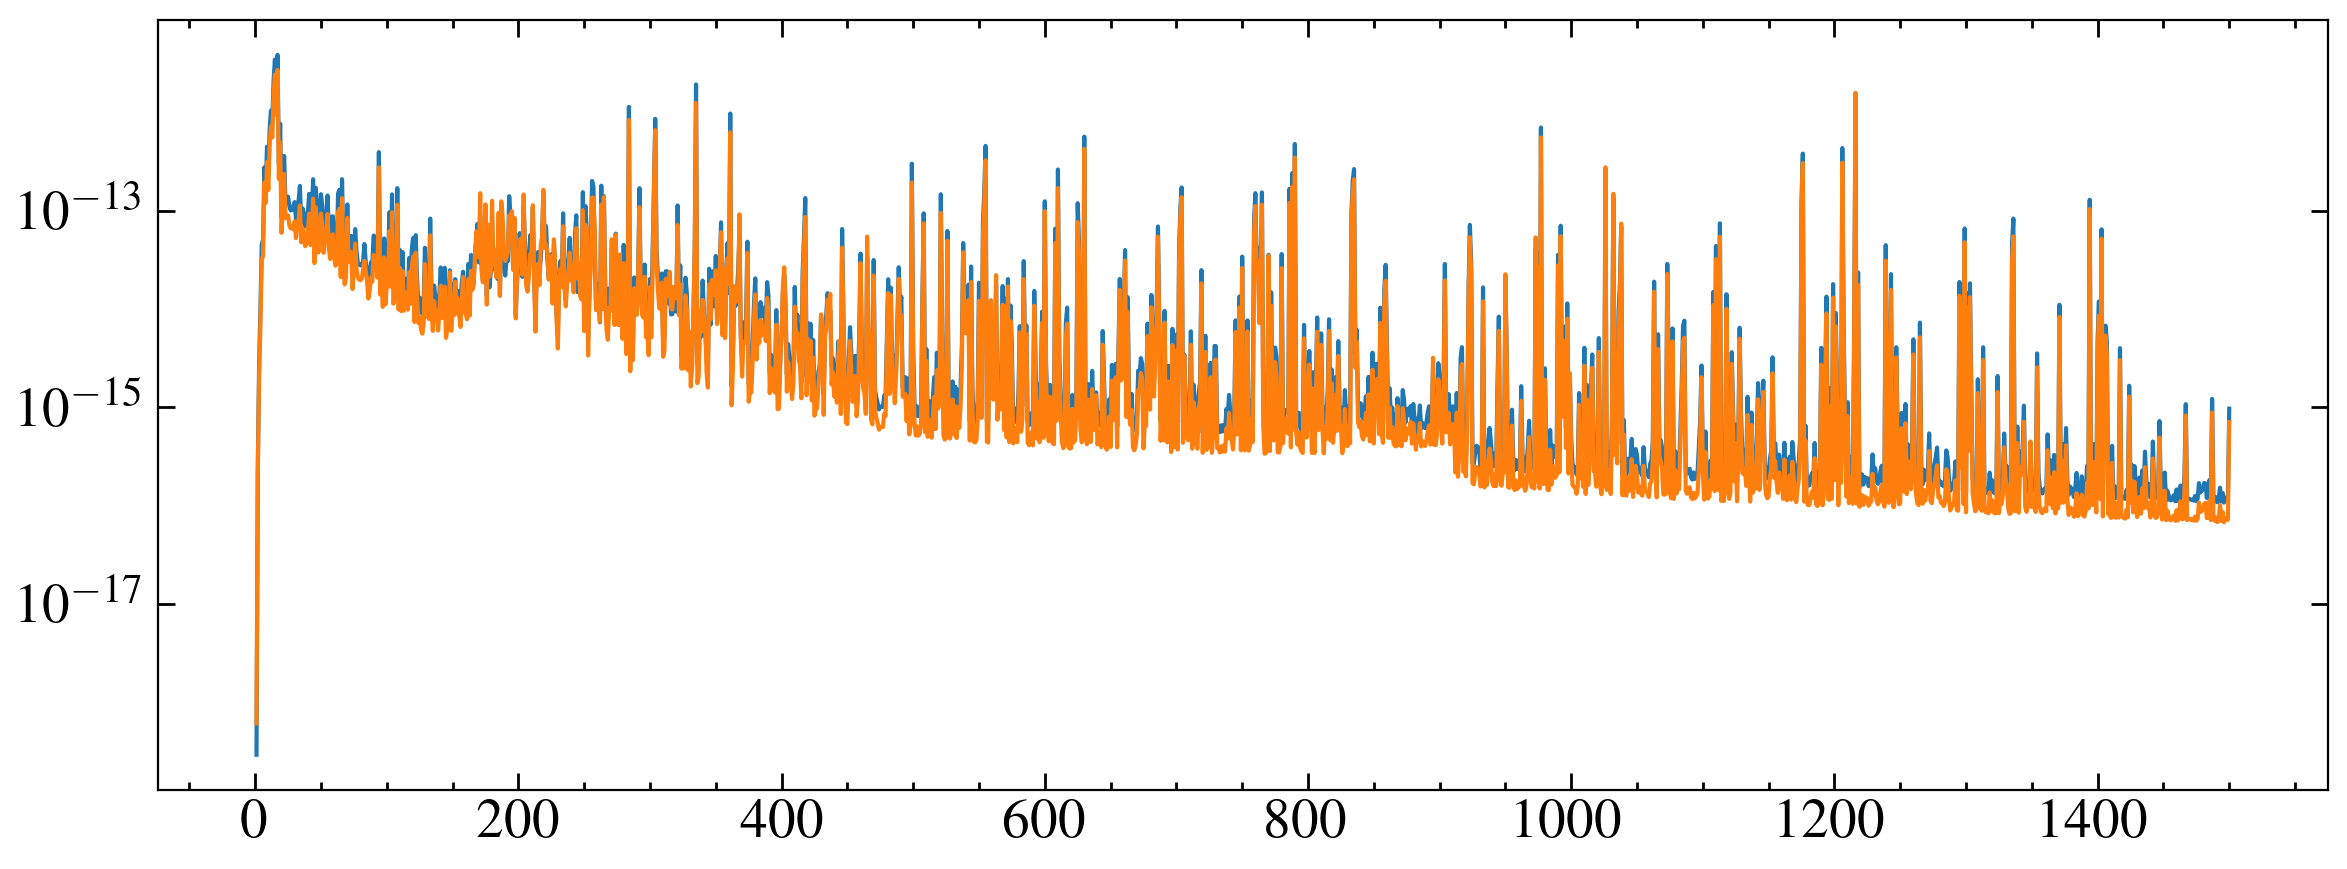

In [27]:
#dem
# dem
dempath = '/media/david/2tb_ext_hd/hddata/yz_cmi/dem/spectrum_yz_cmi_p17.fits'
dem = fits.getdata(dempath, 1)

dw, df= dem['Wavelength'], dem['Flux_density']
eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']


mean_e = np.mean([eu, el], axis=0)
# plt.plot(dw, mean_e)
# plt.yscale('log')

log_mean_e = (eu - el) / (np.log(eu)- np.log(el))

plt.plot(dw, df)
plt.plot(dw, log_mean_e)
# plt.plot(dw, mean_e)

plt.yscale('log')

demtab = Table([dw, df, log_mean_e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
de = log_mean_e
# demtab.write('models/gj_4102_dem.ecsv', overwrite=True)




7.006 38.182
1.0 1500.0
1100.0 2350.8999999988623
2302.9382 3072.4956
501.0 9995000.0


(7.1, 99999)

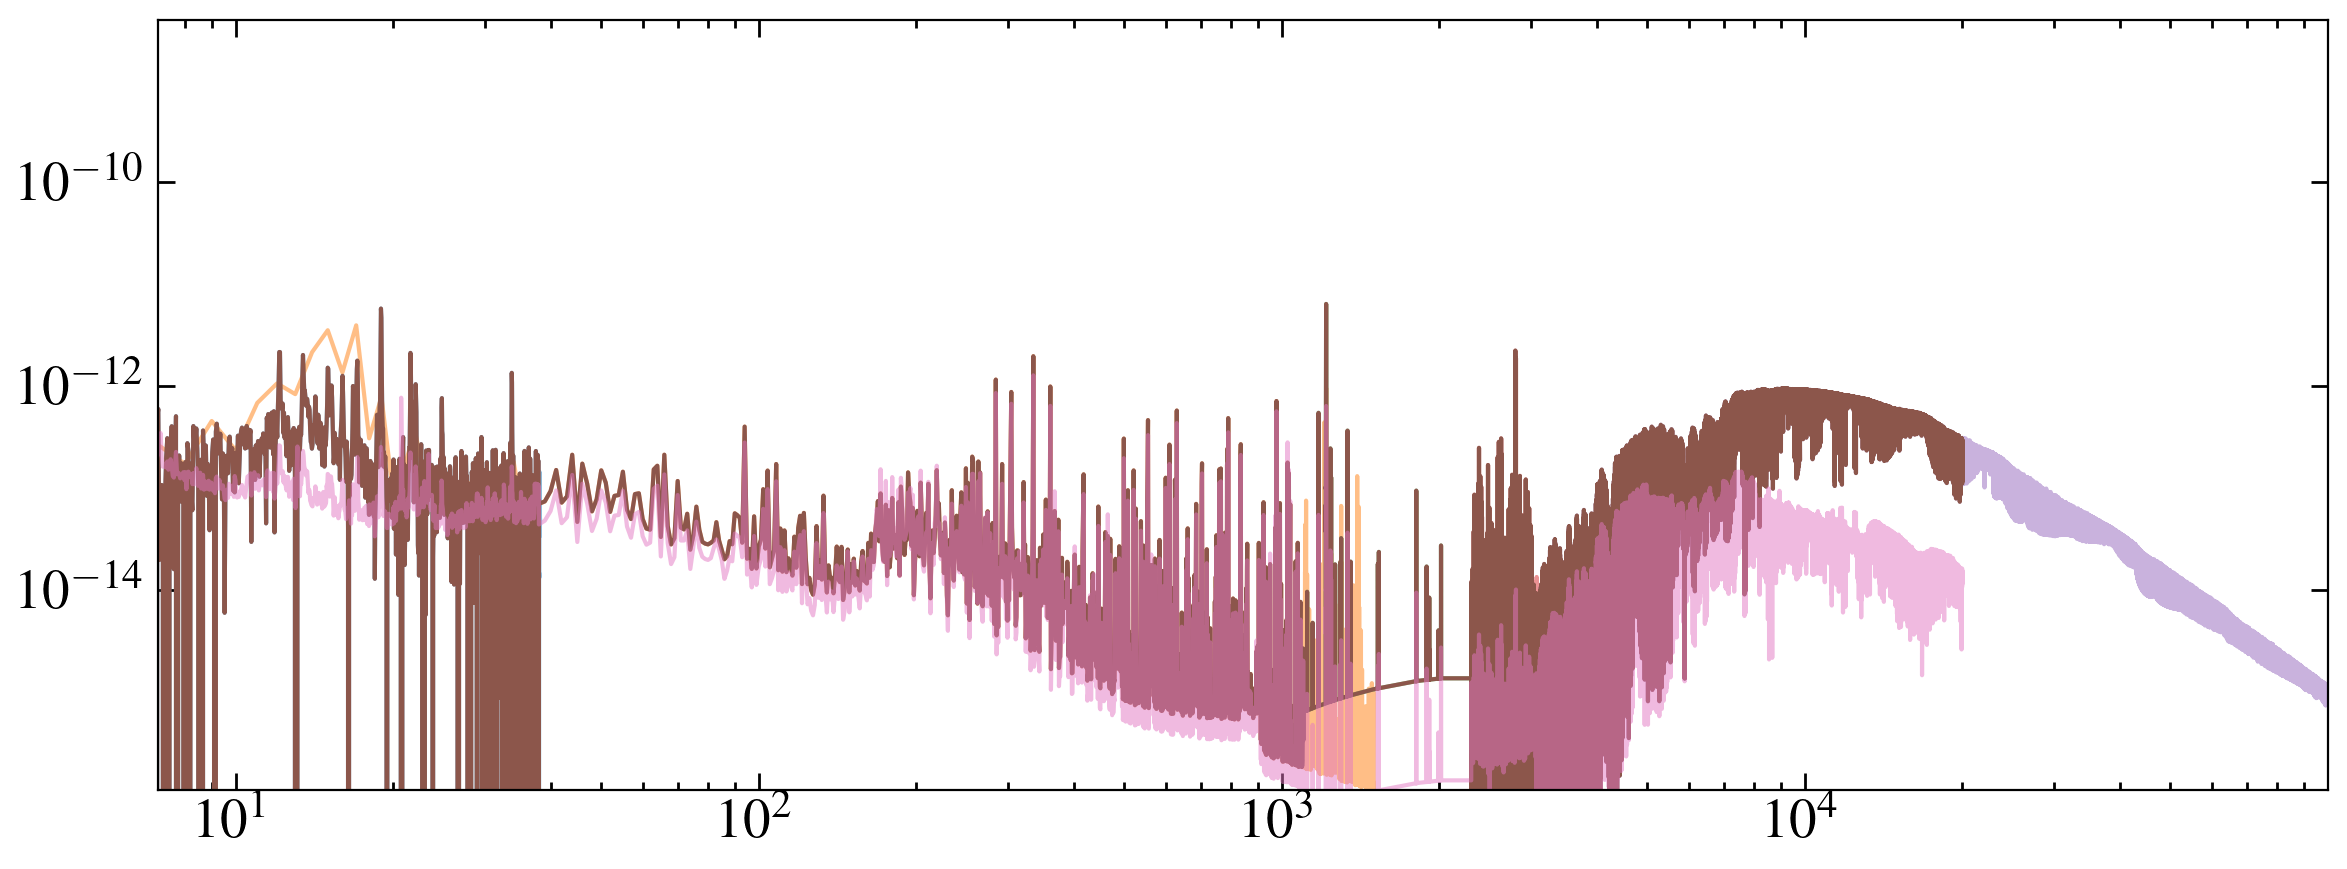

In [28]:
pmask = (pw > 3000) & (pw < 100000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pfi = guass_smooth(pwi, pfi, R=1000)


fig, ax = plt.subplots()

ax.set_yscale('log')
ax.set_xscale('log')


# ws = [xw,  dw, lw, cw, nw, pwi]
# fs = [xf,  df, lf, cf, nf, pfi]


splits = [0, 38, 1100, 2303, 3070, 2e4]


w_all = np.array([])
f_all = np.array([])
e_all = np.array([])

ws = [xw.value,  dw, cw, nw, pw]
fs = [xf.value,  df, cf, nf, pf*normfac]
es = [xe.value, de, cf*0.1, ne, pe*normfac]

for i in range(len(ws)):
    w, f, e = ws[i], fs[i], es[i]
    ax.plot(w, f, alpha=0.5)
    print(w[0], w[-1])
    mask = (w >= splits[i]) & (w <= splits[i+1])
    w_all = np.hstack((w_all, w[mask]))
    f_all = np.hstack((f_all, f[mask]))
    e_all = np.hstack((e_all, e[mask]))
    
ax.plot(w_all, f_all)
ax.plot(w_all, e_all, alpha=0.5)

ax.set_ylim(1.1e-16)
ax.set_xlim(7.1, 99999)

In [32]:
sed= Table([w_all*u.AA, f_all*u.erg/u.s/u.cm**2/u.AA, e_all*u.erg/u.s/u.cm**2/u.AA], names=['WAVELENGTH', 'FLUX', 'ERROR'])
sed.write('draft_seds/yz_cmi_sed_v01.ecsv', format='ascii.ecsv', overwrite=True)

FileNotFoundError: [Errno 2] No such file or directory: 'draft_seds/yz_cmi_sed_v01.ecsv'

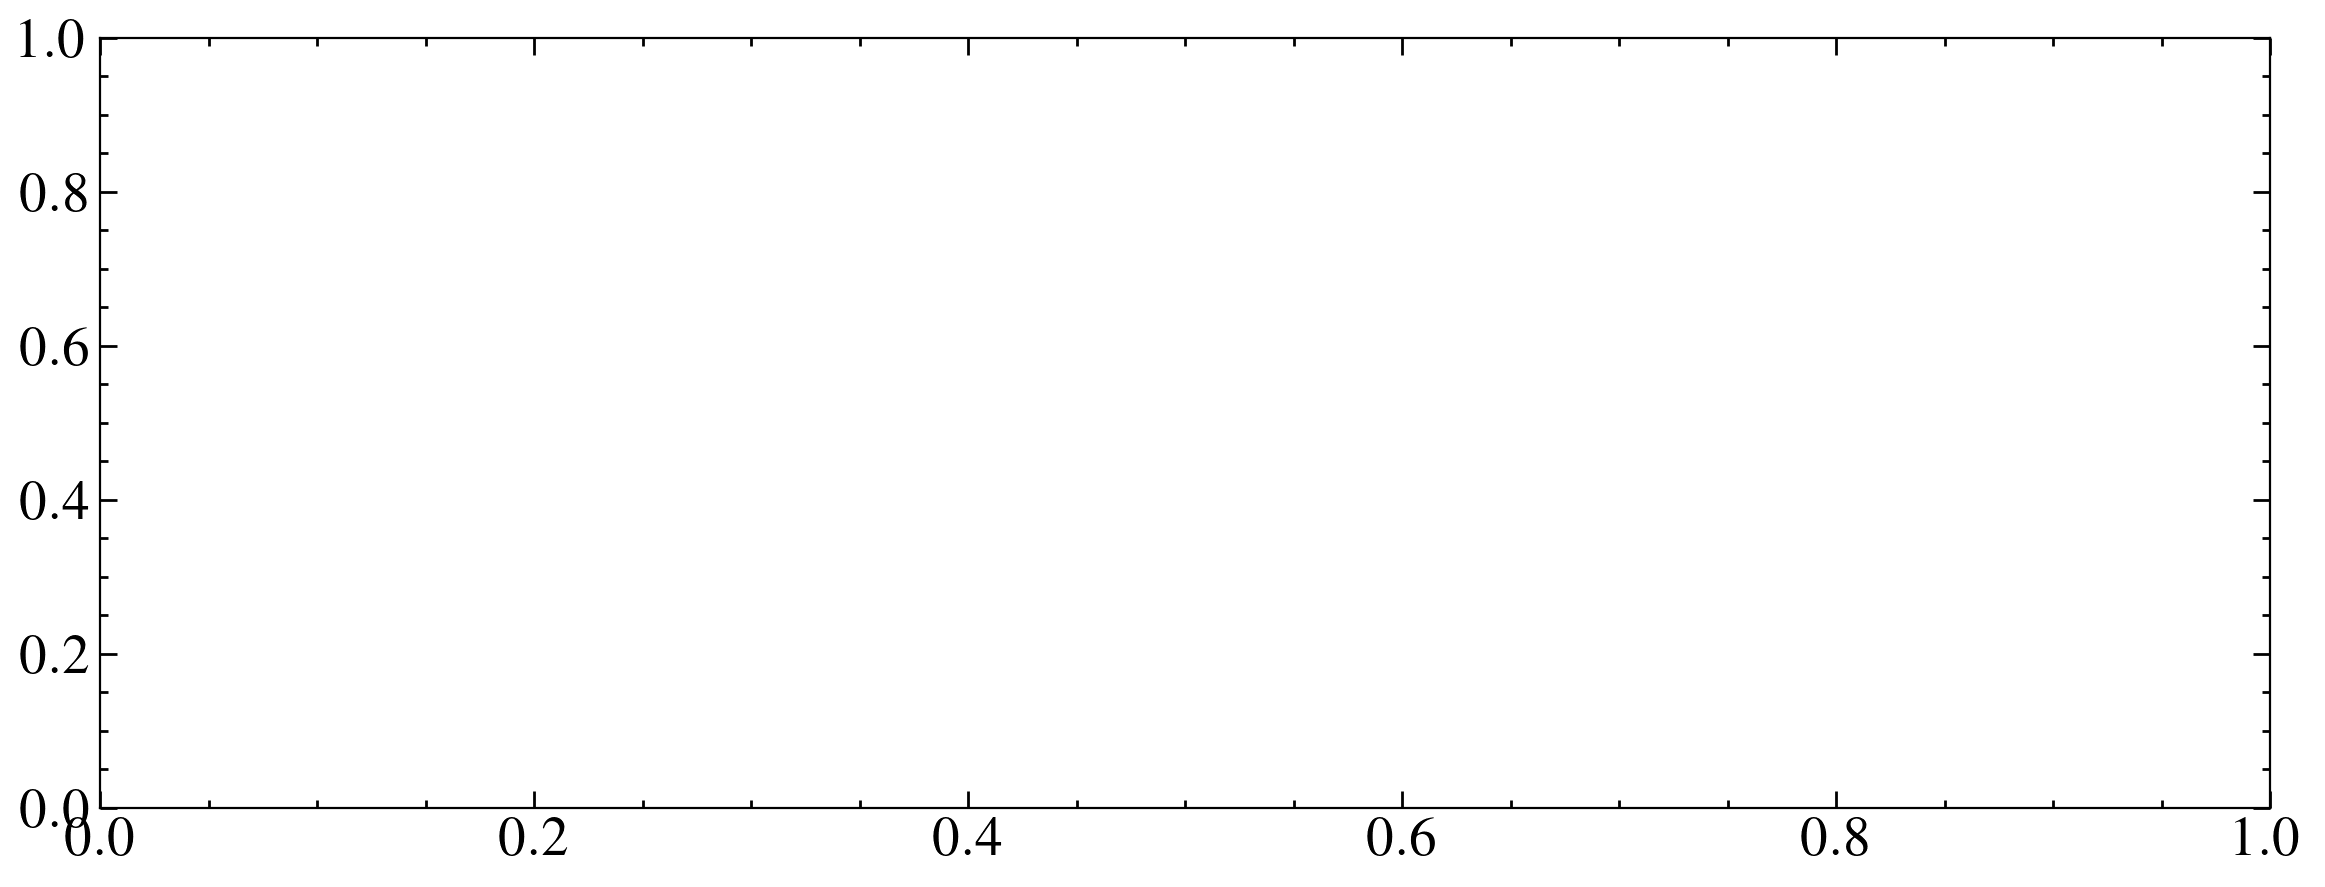

In [31]:
fig, ax = plt.subplots()

sed = Table.read('draft_seds/yz_cmi_sed_v01.ecsv', format='ascii.ecsv')

ax.step(sed['WAVELENGTH'], sed['FLUX'], where='mid')
ax.step(sed['WAVELENGTH'], sed['ERROR'], where='mid', alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
